In [2]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import locale

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

In [5]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

In [6]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [7]:
tbl_debitos_dam_3 = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_3.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam_3)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10


In [8]:
def categorizar_porte(row):
    tipo_propriedade = row['tipo_propriedade']
    area_construida = row['area_construida']

    if tipo_propriedade == 'APARTAMENTO':
        if area_construida <= 60:
            return 'PEQUENO'
        elif 60 < area_construida <= 100:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'CASA':
        if area_construida <= 100:
            return 'PEQUENO'
        elif 100 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'LOJA':
        if area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GARAGEM COMERCIAL':
        if area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'GALPÃO':
        if 200 < area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'

    elif tipo_propriedade == 'SALA':
        if 20 <= area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 150:
            return 'MEDIO'
        else:
            return 'GRANDE'

    else:
        return 'INDEFINIDO'
debitos_divida['tamanho_imovel'] = debitos_divida.apply(categorizar_porte, axis=1)
debitos_divida


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO


In [9]:
arq_bairros = r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\bairro.xlsx'
tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros 

,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [215]:
arq_natureza = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [216]:
debitos_divida = pd.merge(debitos_divida, tbl_pf_pj, on='id_imovel', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,NORDESTE,3A,PF
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,NORDESTE,3A,PF
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,NORDESTE,3A,PF
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,NORDESTE,3A,PF
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,NORDESTE,3A,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,OESTE,4,PF
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,OESTE,4,PF
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,OESTE,4,PF
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,OESTE,4,PF


In [10]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,OESTE,4


In [11]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 834.888.260,11'

In [55]:
teste = debitos_divida.query('idade_imovel == 0')
teste

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
217,00077a2bc81ff832,c2ae2b7db6c1021690ecf5aaf6be6eb7,de05a35e0defad28cd124eb8021f7dca,2023.0,1,92.02,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-12 08:40:53,2023-10-03,0.0,0.0,0.00,753.75,753.75,MEDIO,OESTE,4
3901,0079e32f2b2df516,e39178ab4ca260fc90ecf5aaf6be6eb7,de05a35e0defad28cd124eb8021f7dca,2023.0,1,108.06,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-12 08:40:50,2023-10-03,0.0,0.0,0.00,948.89,948.89,GRANDE,OESTE,4
5762,00b7e65deba04f66,a2d6c048012e096a90ecf5aaf6be6eb7,96612558770ddfc9b21d3090ade9901c,2023.0,1,115.82,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-04-04 12:51:18,2023-10-24,0.0,0.0,0.00,718.99,718.99,GRANDE,NORDESTE,3A
9071,01225d25eb8588b2,bba2ee67bc2fa94290ecf5aaf6be6eb7,6de005654fc2ff2a344d77602867ec09,2023.0,1,150.65,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-06-16 09:10:29,2023-09-14,0.0,0.0,1890.90,0.00,1890.90,GRANDE,NORDESTE,3A
13420,01ac5050d318e06f,6cb5b9816bff83da875350beaddc7871,8e4a7d92140ae2a4e6901afaaadfa50b,2022.0,1,122.09,1,P,SALA,CONSTRUÍDA,...,2023-05-18 09:11:16,2023-07-19,0.0,0.0,0.00,771.65,771.65,MEDIO,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010081,ff24a161e661270e,81f8e0e15204e30a90ecf5aaf6be6eb7,53a36334111ac7d3f97f140db443201a,2023.0,1,105.05,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-08-18 09:51:50,2023-11-24,0.0,0.0,0.00,322.17,322.17,GRANDE,OESTE,4
2013202,ff87adefa4ad0a6e,c76ffdb220470b7890ecf5aaf6be6eb7,b3036ccd34e8da8da826929202e23808,2023.0,1,922.76,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-03-20 09:25:08,2023-05-04,0.0,0.0,12562.41,8500.53,21062.94,GRANDE,SUL,6
2014286,ffab650b73779a86,ba0ff712331a365990ecf5aaf6be6eb7,72f95aa88c8eb7f50246e2b93c1bf25c,2023.0,1,107.12,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-06-16 09:10:29,2023-10-05,0.0,0.0,1153.87,0.00,1153.87,GRANDE,NORDESTE,3A
2015827,ffdd5abf53f1f49d,9749cfe26f8abbc390ecf5aaf6be6eb7,36c321aafc4010b32d8601c4899b8575,2023.0,1,78.59,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-07-06 14:54:48,2023-08-15,0.0,0.0,0.00,1047.18,1047.18,MEDIO,NORDESTE,3B


In [56]:
formatar_moeda(teste['vlr_aberto'].sum())

'R$ 3,552,863.19'

---

## Análise imóveis com idade menor que 20 anos

In [628]:
idade_imo_20_anos = debitos_divida.query('idade_imovel > 0 & idade_imovel <= 20')
idade_imo_20_anos

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
13,0000a2cbd951c1ca,08de56599e513fba11babe4a46e18b6d,c2357fdb65f5cbed8e79cf1867e8cc19,2018.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-01-19,1.0,19.0,2698.70,0.0,2698.70,GRANDE,SUL,6,PF
14,0000a2cbd951c1ca,621779c21ab522df875350beaddc7871,c2357fdb65f5cbed8e79cf1867e8cc19,2022.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-09-11,0.0,19.0,3713.31,0.0,3780.80,GRANDE,SUL,6,PF
15,0000a2cbd951c1ca,b11c994dea432c034c1f696350fff79e,c2357fdb65f5cbed8e79cf1867e8cc19,2019.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-01-16,1.0,19.0,3098.40,0.0,3098.40,GRANDE,SUL,6,PF
16,0000a2cbd951c1ca,c443544fa11703410ba9f03948490762,c2357fdb65f5cbed8e79cf1867e8cc19,2020.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2020-11-10,0.0,19.0,3168.60,0.0,3168.60,GRANDE,SUL,6,PF
17,0000a2cbd951c1ca,ce1496e9eeece7dfe08920064611a7cf,c2357fdb65f5cbed8e79cf1867e8cc19,2017.0,1,174.01,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-25,1.0,19.0,2633.80,0.0,2633.80,GRANDE,SUL,6,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016931,fffd8973eae22105,d71425c6a4b4c3b819002eec9f619408,2af853905b920a011ed8b02446055311,2021.0,1,175.55,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-02-10,1.0,11.0,3567.30,0.0,3567.30,GRANDE,SUL,6,PF
2016953,fffe35404991181f,5e8b4705b3998d50875350beaddc7871,eaf1b50bdb8acc5dbc4e99972848013d,2022.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-01-06,1.0,4.0,7479.60,0.0,7479.60,GRANDE,SUL,6,PF
2016954,fffe35404991181f,84502415a128bec519002eec9f619408,eaf1b50bdb8acc5dbc4e99972848013d,2021.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-01-25,1.0,4.0,6760.70,0.0,6760.70,GRANDE,SUL,6,PF
2016955,fffe35404991181f,9466f976b7a7542c90ecf5aaf6be6eb7,eaf1b50bdb8acc5dbc4e99972848013d,2023.0,1,265.25,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-01-26,1.0,4.0,7545.30,0.0,7545.30,GRANDE,SUL,6,PF


In [627]:
formatar_moeda(idade_imo_20_anos['vlr_aberto'].sum())

'R$ 417.766.644,96'

In [52]:
formatar_moeda(idade_imo_20_anos['vlr_pago'].sum())

'R$ 1,912,633,143.66'

In [353]:
filtro = idade_imo_20_anos.query('tamanho_imovel == "INDEFINIDO"')
soma = formatar_moeda(filtro['vlr_pago'].sum())
soma

'R$ 283,957,381.44'

In [354]:
53427784.69 / (53427784.69 + 283957381.44) * 100

15.835842844795792

In [359]:
53427784.69 * 0.85

45413616.986499995

In [58]:
filtro = idade_imo_20_anos.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['tipo_propriedade'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_count', ascending=False).drop(columns='total_count')
pivot_table


,tipo_propriedade,PEQUENO,MEDIO,GRANDE,INDEFINIDO
0,APARTAMENTO,5764,34299,44035,0
17,SALA,1036,5482,1187,0
1,CASA,1787,1269,972,0
13,LOJA,795,946,580,0
2,CENTRO COMERCIAL/SERVIÇOS,0,0,0,741
4,GALPÃO,0,0,0,733
3,EDIFICAÇÃO ESPECIAL,0,0,0,645
6,GARAGEM COMERCIAL,591,3,18,0
9,HOTEL,0,0,0,96
10,INDUSTRIA,0,0,0,56


### Soma por porte

In [59]:
soma_colunas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=0)
df_soma_colunas = pd.DataFrame(soma_colunas, columns=['Soma_Total'])
df_soma_colunas = df_soma_colunas.T
df_soma_colunas

,PEQUENO,MEDIO,GRANDE,INDEFINIDO
Soma_Total,9973,41999,46792,2502


In [360]:
9973 + 41999 + 46792 + 2502

101266

In [368]:
41999 / 101266 * 100

41.47393992060514

### Soma por tipo_propriedade

In [60]:
soma_linhas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=1)
df_soma_linhas = pd.DataFrame({'tipo_propriedade': pivot_table['tipo_propriedade'], 'Total_imoveis': soma_linhas})
df_soma_linhas

,tipo_propriedade,Total_imoveis
0,APARTAMENTO,84098
17,SALA,7705
1,CASA,4028
13,LOJA,2321
2,CENTRO COMERCIAL/SERVIÇOS,741
4,GALPÃO,733
3,EDIFICAÇÃO ESPECIAL,645
6,GARAGEM COMERCIAL,612
9,HOTEL,96
10,INDUSTRIA,56


In [332]:
filtro = idade_imo_20_anos.query('tamanho_imovel == "PEQUENO"')
# filtro = filtro.query('tipo_propriedade == "APARTAMENTO"')
filtro = filtro.query('vlr_aberto > 0')

contagem_bairros = filtro.groupby('bairro')['id_imovel'].nunique().reset_index()
contagem_bairros.columns = ['bairro', 'quantidade_id_imovel']
contagem_bairros['soma_vlr_aberto'] = filtro.groupby('bairro')['vlr_aberto'].sum().values
contagem_bairros['Pode_ser_pago'] = contagem_bairros['soma_vlr_aberto'] * 0.87
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)
# contagem_bairros['soma_vlr_aberto'] = contagem_bairros['soma_vlr_aberto'].apply(formatar_moeda)

contagem_bairros.head(10)

,bairro,quantidade_id_imovel,soma_vlr_aberto,Pode_ser_pago
11,BOA VIAGEM,669,1040075.72,904865.8764
81,VARZEA,407,445494.11,387579.8757
8,ARRUDA,356,252501.87,219676.6269
63,PINA,150,203154.00,176743.9800
46,IPUTINGA,119,154897.28,134760.6336
30,CURADO,135,144397.46,125625.7902
48,JARDIM SAO PAULO,135,140677.64,122389.5468
68,ROSARINHO,48,135135.33,117567.7371
28,CORDEIRO,92,119895.02,104308.6674
38,GRACAS,79,119169.80,103677.7260


In [333]:
formatar_moeda(contagem_bairros['soma_vlr_aberto'].sum())

'R$ 4,543,079.39'

In [335]:
formatar_moeda(contagem_bairros['Pode_ser_pago'].sum())

'R$ 3,952,479.07'

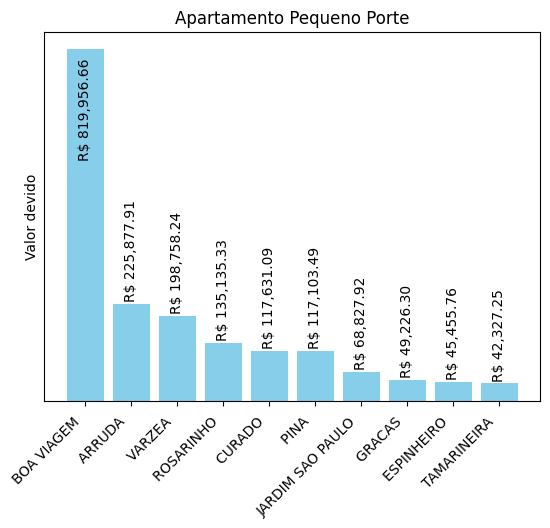

In [273]:
import matplotlib.pyplot as plt

def formatar_moeda(valor):
    return f'R$ {valor:,.2f}'

contagem_bairros = contagem_bairros.head(10)
fig, ax = plt.subplots()
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)
bars = ax.bar(contagem_bairros['bairro'], contagem_bairros['soma_vlr_aberto'], color='skyblue')

# ax.set_xlabel('Bairros')
ax.set_ylabel('Valor devido')
ax.set_title('Apartamento Pequeno Porte')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks([])

for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 1:
        xytext_config = (0, -80) 
    elif 1 <= i < 9:
        xytext_config = (0, 2) 
    else:
        xytext_config = (0, 1) 
    ax.annotate(formatar_moeda(yval),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)
plt.show()

In [96]:
filtro = idade_imo_20_anos.query('tamanho_imovel == "PEQUENO"')
filtro = filtro.query('tipo_propriedade == "APARTAMENTO"')

filtro = filtro[filtro['bairro'].str.strip() == 'ARRUDA']
soma = formatar_moeda(filtro['vlr_aberto'].sum())
soma

'R$ 225.877,91'

## Análise imóveis com idade maior que 20 anos e menor ou igual a 50 anos

In [217]:
idade_imo_menor_50_anos = debitos_divida.query('idade_imovel > 20 & idade_imovel <= 50')
idade_imo_menor_50_anos

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,NORDESTE,3A,PF
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,NORDESTE,3A,PF
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,NORDESTE,3A,PF
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,NORDESTE,3A,PF
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,NORDESTE,3A,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,OESTE,4,PF
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,OESTE,4,PF
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,OESTE,4,PF
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,OESTE,4,PF


In [26]:
idade_imo_menor_50_anos.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10,GRANDE,NORDESTE,3A
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70,GRANDE,NORDESTE,3A
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10,GRANDE,NORDESTE,3A
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40,GRANDE,NORDESTE,3A
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37,GRANDE,NORDESTE,3A


In [24]:
formatar_moeda(idade_imo_menor_50_anos['vlr_pago'].sum())

'R$ 2.047.929.984,30'

In [54]:
aux = idade_imo_menor_50_anos.query('id_imovel == "7fc384b63bacf3c4" ')
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
1008171,7fc384b63bacf3c4,81748f17002ead2290ecf5aaf6be6eb7,NaN,2023.0,2,299.28,1,P,CASA,CONSTRUÍDA,...,2008-12-11 18:27:33,2023-03-15,0.0,41.0,0.0,12208.68,12208.68,GRANDE,NORDESTE,3A
1008172,7fc384b63bacf3c4,b89e73d1b54bda18875350beaddc7871,NaN,2022.0,2,299.28,1,P,CASA,CONSTRUÍDA,...,2008-12-11 18:27:33,2022-12-16,0.0,41.0,0.0,13739.74,13739.74,GRANDE,NORDESTE,3A


In [18]:
formatar_moeda(aux['vlr_pago'].sum())

'R$ 20.280,77'

In [57]:
14613/188481 * 100

7.753036115046079

## Verificando se há mais de um contribuinte vinculado a um mesmo imóvel

In [169]:
aux = idade_imo_menor_50_anos.query('id_imovel == "fffee3cacb174a68"')
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
2016990,fffee3cacb174a68,2827aeded01bfeae0ba9f03948490762,76ab1d625a4a69d0d8b209292c0ce31d,2020.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2020-11-09,0.0,41.0,547.30,0.0,547.30,MEDIO,OESTE,4
2016991,fffee3cacb174a68,a8033c6d8d84fa6c4c1f696350fff79e,76ab1d625a4a69d0d8b209292c0ce31d,2019.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2019-11-11,0.0,41.0,535.60,0.0,535.60,MEDIO,OESTE,4
2016992,fffee3cacb174a68,aaaca04ff960a1a5875350beaddc7871,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2022-11-09,0.0,41.0,626.75,0.0,628.62,MEDIO,OESTE,4
2016993,fffee3cacb174a68,c0ff37bd120cc0d619002eec9f619408,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2021-11-08,0.0,41.0,568.39,0.0,570.09,MEDIO,OESTE,4
2016994,fffee3cacb174a68,c8d60514c5f4b18ee08920064611a7cf,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2017-11-10,0.0,41.0,503.20,0.0,503.20,MEDIO,OESTE,4
2016995,fffee3cacb174a68,e46ab0c52787357611babe4a46e18b6d,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2018-11-09,0.0,41.0,515.10,0.0,515.10,MEDIO,OESTE,4
2016996,fffee3cacb174a68,eef10f2cae56542390ecf5aaf6be6eb7,76ab1d625a4a69d0d8b209292c0ce31d,2023.0,1,89.15,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 19:34:01,2023-10-10,0.0,41.0,666.76,0.0,670.73,MEDIO,OESTE,4


In [164]:
idade_imo_menor_50_anos = pd.DataFrame(idade_imo_menor_50_anos)
contagem_registros = idade_imo_menor_50_anos.groupby('id_imovel')['id_contribuinte'].nunique()
resultado_df = pd.DataFrame({'id_imovel': contagem_registros.index, 'contagem_diferentes': contagem_registros.values})
resultado_df

,id_imovel,contagem_diferentes
0,000032f6d93a0abd,1
1,00006a4fa855b308,1
2,0000e13a7d8d7537,0
3,0001114d1e8d6c46,1
4,0001cc5c538504ce,1
...,...,...
188476,fffdec331c341742,1
188477,fffe81929d58562b,1
188478,fffe9f81e524f143,1
188479,fffedcc05be9beaa,1


In [167]:
resultado_df.describe()

,contagem_diferentes
count,188481.000000
mean,0.922470
std,0.267432
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [161]:
grupo_por_id = idade_imo_menor_50_anos.groupby(['id_imovel', 'id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    'bairro': 'first'
}).reset_index()
grupo_por_id

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,bairro
0,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,0.00,20280.77,38.0,GRANDE,TAMARINEIRA
1,00006a4fa855b308,d87e514082d2101ed4613fe022d53698,0.00,1432.41,39.0,PEQUENO,IPUTINGA
2,0001114d1e8d6c46,a4f9a6068e4b0327cd124eb8021f7dca,5259.93,10123.15,41.0,GRANDE,IPUTINGA
3,0001cc5c538504ce,fc7913336ff7c55a0246e2b93c1bf25c,636.89,0.00,35.0,PEQUENO,COHAB
4,00024c0c1dd569b1,66c95eb4f8574e47cd124eb8021f7dca,2277.53,1685.68,46.0,MEDIO,BOA VIAGEM
...,...,...,...,...,...,...,...
173863,fffdec331c341742,031e497f3562f933e2b6efb9fff47cce,0.00,4261.20,34.0,PEQUENO,CAXANGA
173864,fffe81929d58562b,e2d626743470e5e10246e2b93c1bf25c,1174.22,18725.66,28.0,MEDIO,BOA VIAGEM
173865,fffe9f81e524f143,703f3d5c6a8711e475234379af146d63,0.00,7084.80,42.0,PEQUENO,BOA VIAGEM
173866,fffedcc05be9beaa,f995d12c76cce604d65600efcabb160f,0.00,10400.41,22.0,GRANDE,PRADO


In [13]:
ibura = idade_imo_menor_50_anos[idade_imo_menor_50_anos['bairro'].str.strip() == 'IBURA']
ibura

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:19:51,2022-12-16,0.0,30.0,0.00,995.55,995.55,INDEFINIDO,SUL,6B
277,0008e8e909bb4f70,f7cbbdb5ab7059db90ecf5aaf6be6eb7,b1b8a6102d62c900179357218888e6f8,2023.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:19:51,2023-03-15,0.0,30.0,0.00,887.21,887.21,INDEFINIDO,SUL,6B
945,001e227b0d1a0fe9,1224a1e8ee8b8b82e08920064611a7cf,68a9fbcc48fb1f2c0246e2b93c1bf25c,2017.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:52:02,2017-06-09,0.0,37.0,378.52,0.00,378.52,PEQUENO,SUL,6B
946,001e227b0d1a0fe9,3c311138f6b021140ba9f03948490762,68a9fbcc48fb1f2c0246e2b93c1bf25c,2020.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:52:02,2020-01-22,1.0,37.0,412.40,0.00,412.40,PEQUENO,SUL,6B
947,001e227b0d1a0fe9,404b5efb1457eebd11babe4a46e18b6d,68a9fbcc48fb1f2c0246e2b93c1bf25c,2018.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:52:02,2018-01-23,1.0,37.0,387.36,0.00,387.36,PEQUENO,SUL,6B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016718,fff83859ee49b2ca,8e003139e2a356784c1f696350fff79e,0aa0a2ca68b629d5be91dcec7d89e48e,2019.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2019-02-06,1.0,39.0,288.48,0.00,288.48,PEQUENO,SUL,6B
2016719,fff83859ee49b2ca,9d5ac41e481a0b1e875350beaddc7871,0aa0a2ca68b629d5be91dcec7d89e48e,2022.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2022-02-08,1.0,39.0,334.38,0.00,334.38,PEQUENO,SUL,6B
2016720,fff83859ee49b2ca,eab9fa6438f3d33019002eec9f619408,0aa0a2ca68b629d5be91dcec7d89e48e,2021.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2021-02-08,1.0,39.0,303.90,0.00,303.90,PEQUENO,SUL,6B
2016721,fff83859ee49b2ca,eed29dbf8ce4aa64e08920064611a7cf,0aa0a2ca68b629d5be91dcec7d89e48e,2017.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2017-02-03,1.0,39.0,271.44,0.00,271.44,PEQUENO,SUL,6B


In [14]:
formatar_moeda(ibura['vlr_aberto'].sum())

'R$ 10.493.413,89'

In [198]:
10493413.89 + 4872008.53 + 19859496.27 + 7937572.68

43162491.37

In [183]:
220768.94 / 2735

80.71990493601463

---

# IBURA

* HOUVE AUMENTO DE IMÓVEIS SIGNIFICATIVO DE 2021 PARA 2022

In [15]:
ibura = pd.DataFrame(ibura)

ibura_filtrado = ibura[ibura['vlr_pago'] != 0]
ticket_medio_df = ibura_filtrado.groupby('ano_fato_gerador')[['vlr_pago']].mean().reset_index()

ticket_medio_df = ticket_medio_df.rename(columns={'vlr_pago': 'ticket_medio_pago'})
ticket_medio_df['ticket_medio_pago'] = ticket_medio_df['ticket_medio_pago'].apply(formatar_moeda)
ticket_medio_df

,ano_fato_gerador,ticket_medio_pago
0,2017.0,"R$ 865,09"
1,2018.0,"R$ 971,28"
2,2019.0,"R$ 967,44"
3,2020.0,"R$ 987,84"
4,2021.0,"R$ 1.071,60"
5,2022.0,"R$ 1.128,80"
6,2023.0,"R$ 1.169,38"


In [188]:
ibura = pd.DataFrame(ibura)

ibura_filtrado = ibura[ibura['vlr_aberto'] != 0]
ticket_medio_df = ibura_filtrado.groupby('ano_fato_gerador')[['vlr_aberto']].mean().reset_index()

ticket_medio_df = ticket_medio_df.rename(columns={'vlr_aberto': 'ticket_medio_aberto'})
ticket_medio_df['ticket_medio_aberto'] = ticket_medio_df['ticket_medio_aberto'].apply(formatar_moeda)
ticket_medio_df

,ano_fato_gerador,ticket_medio_aberto
0,2017.0,"R$ 1.098,35"
1,2018.0,"R$ 1.741,79"
2,2019.0,"R$ 1.593,23"
3,2020.0,"R$ 1.588,25"
4,2021.0,"R$ 1.382,42"
5,2022.0,"R$ 1.572,63"
6,2023.0,"R$ 1.411,38"


In [16]:
filtro = ibura.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['tipo_propriedade'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_count', ascending=False).drop(columns='total_count')
pivot_table

,tipo_propriedade,PEQUENO,MEDIO,GRANDE,INDEFINIDO
1,CASA,2154,379,82,0
0,APARTAMENTO,1228,180,7,0
3,GALPÃO,0,0,0,180
9,LOJA,59,37,23,0
11,SALA,26,7,4,0
2,EDIFICAÇÃO ESPECIAL,0,0,0,25
7,INDUSTRIA,0,0,0,6
6,HOTEL,0,0,0,2
4,GALPÃO FECHADO,0,0,0,1
5,GARAGEM COMERCIAL,1,0,0,0


In [17]:
ibura = pd.DataFrame(ibura)
contagem_imoveis = ibura.groupby(['tipo_propriedade', 'ano_fato_gerador'])['id_imovel'].nunique().reset_index()
contagem_pivotada = contagem_imoveis.pivot(index='tipo_propriedade', columns='ano_fato_gerador', values='id_imovel').fillna(0)
contagem_pivotada

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,892.0,820.0,869.0,831.0,789.0,1414.0,1413.0
CASA,1252.0,1101.0,1209.0,1153.0,1122.0,2573.0,2572.0
EDIFICAÇÃO ESPECIAL,17.0,18.0,16.0,13.0,14.0,24.0,24.0
GALPÃO,90.0,94.0,94.0,81.0,82.0,175.0,178.0
GALPÃO FECHADO,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GARAGEM COMERCIAL,0.0,0.0,0.0,0.0,0.0,1.0,1.0
HOTEL,1.0,1.0,1.0,0.0,0.0,2.0,2.0
INDUSTRIA,4.0,5.0,5.0,5.0,4.0,6.0,6.0
INSTITUIÇÃO FINANCEIRA,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [68]:
teste = idade_imo_menor_50_anos.query('id_imovel =="002fda9d8daf0861"')
teste

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
1495,002fda9d8daf0861,65ddedb2d86a075090ecf5aaf6be6eb7,dbfd0bc68a16f38db52d42c6eb89d24d,2023.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:02:35,2023-11-20,0.0,40.0,0.0,711.26,711.26,INDEFINIDO,SUL,6B
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:02:35,2022-11-19,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,SUL,6B


# Análises em IBURA

In [70]:
ibura = pd.DataFrame(ibura)

# Ordenando o DataFrame por ano_fato_gerador
ibura = ibura.sort_values(by='ano_fato_gerador')
imoveis_que_desaparecem = ibura.groupby('id_imovel')['ano_fato_gerador'].apply(lambda x: x.ne(x.shift(-1)) & x.ne(x.shift(1))).reset_index(name='desaparece')
imoveis_que_desaparecem_e_reaparecem = imoveis_que_desaparecem[imoveis_que_desaparecem['desaparece']]

# Exibindo os resultados
imoveis_que_desaparecem_e_reaparecem

,id_imovel,level_1,desaparece
0,0008e8e909bb4f70,276,True
1,0008e8e909bb4f70,277,True
2,001e227b0d1a0fe9,945,True
3,001e227b0d1a0fe9,947,True
4,001e227b0d1a0fe9,949,True
...,...,...,...
23614,fff83859ee49b2ca,2016718,True
23615,fff83859ee49b2ca,2016717,True
23616,fff83859ee49b2ca,2016720,True
23617,fff83859ee49b2ca,2016719,True


In [98]:
aux = ibura.query('ano_fato_gerador == 2023')
aux = aux.query('id_imovel == "fff83859ee49b2ca"')
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
2016722,fff83859ee49b2ca,f0db4459fbbd7d5f90ecf5aaf6be6eb7,0aa0a2ca68b629d5be91dcec7d89e48e,2023.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2023-03-01,0.0,39.0,355.58,0.0,357.34,PEQUENO,SUL,6B


In [100]:
ibura = pd.DataFrame(ibura)
# apartamentos = ibura[ibura['tipo_propriedade'] == 'APARTAMENTO']
# apartamentos = apartamentos[apartamentos['tamanho_imovel'] == 'PEQUENO']
contagem_apartamentos = ibura.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_apartamentos = contagem_apartamentos.rename(columns={'id_imovel': 'contagem_apartamentos'})
contagem_apartamentos

,ano_fato_gerador,contagem_apartamentos
0,2017.0,2723
1,2018.0,2442
2,2019.0,2636
3,2020.0,2490
4,2021.0,2414
5,2022.0,5430
6,2023.0,5433


In [65]:
# Chunk para analisar imóveis que estão em um ano e não estão em outro
ibura = pd.DataFrame(ibura)

imoveis_2021 = ibura[ibura['ano_fato_gerador'] == 2021]['id_imovel'].unique()
imoveis_2022 = ibura[ibura['ano_fato_gerador'] == 2022]['id_imovel'].unique()

imoveis_nao_presentes_2021 = set(imoveis_2022) - set(imoveis_2021)
imoveis_nao_presentes_df = ibura[ibura['id_imovel'].isin(imoveis_nao_presentes_2021) & (ibura['ano_fato_gerador'] == 2022)].drop_duplicates(subset='id_imovel')
imoveis_nao_presentes_df

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:19:51,2022-12-16,0.0,30.0,0.0,995.55,995.55,INDEFINIDO,SUL,6B
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:20:08,2022-06-16,0.0,24.0,0.0,357.48,357.48,PEQUENO,SUL,6B
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:35:24,2022-10-20,0.0,23.0,0.0,672.86,672.86,PEQUENO,SUL,6B
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,2008-12-11 21:22:00,2023-10-31,0.0,29.0,449.0,0.00,521.53,PEQUENO,SUL,6B
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,2008-12-11 21:02:35,2022-11-19,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,SUL,6B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014358,ffad1ef07d3db126,a21fa2c690385311875350beaddc7871,NaN,2022.0,2,114.19,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:18:00,2022-12-16,0.0,24.0,0.0,896.30,896.30,MEDIO,SUL,6B
2014850,ffbd4625122de737,bb0a8374755b79db875350beaddc7871,43a02617639cfbc4a79038f64d77cadf,2022.0,1,93.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:02:41,2022-12-16,0.0,41.0,0.0,980.64,980.64,PEQUENO,SUL,6B
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,2008-12-11 22:58:34,2022-12-16,0.0,36.0,0.0,7855.98,7855.98,INDEFINIDO,SUL,6B
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,2008-12-11 21:18:32,2022-12-16,0.0,33.0,0.0,10416.93,10416.93,INDEFINIDO,SUL,6B


In [ ]:
ap_2021 = ibura.query('tipo_propriedade == "APARTAMENTO"')
ap_2021 = ap_2021.query('ano_fato_gerador == 2021')
ap_2021 = ap_2021.query('tamanho_imovel == "PEQUENO"')
ap_2021

In [63]:
formatar_moeda(ap_2021['vlr_aberto'].sum())

'R$ 7.685,29'

In [64]:
formatar_moeda(ap_2021['vlr_pago'].sum())

'R$ 220.458,75'

In [ ]:
ap_2022 = ibura.query('tipo_propriedade == "CASA"')
ap_2022 = ap_2022.query('ano_fato_gerador == 2022')
ap_2022 = ap_2022.query('tamanho_imovel == "PEQUENO"')
ap_2022

In [56]:
formatar_moeda(ap_2022['vlr_aberto'].sum())

'R$ 776.511,71'

In [ ]:
formatar_moeda(ap_2022['vlr_pago'].sum())

In [57]:
ap_2022_sem_2021 = imoveis_nao_presentes_df.query('tipo_propriedade == "CASA"')
ap_2022_sem_2021 = ap_2022_sem_2021.query('tamanho_imovel == "PEQUENO"')
ap_2022_sem_2021

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:20:08,2022-06-16,0.0,24.0,0.00,357.48,357.48,PEQUENO,SUL,6B
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:35:24,2022-10-20,0.0,23.0,0.00,672.86,672.86,PEQUENO,SUL,6B
2392,004950389aec0608,dec1b6491948c37d875350beaddc7871,4bd7101853dbeea6be91dcec7d89e48e,2022.0,1,86.58,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:05:10,2022-12-16,0.0,41.0,65.24,856.15,921.39,PEQUENO,SUL,6B
4764,0097b1bcbc1c6b69,949841002898c14f875350beaddc7871,523a28f1ff46ff7f6eb22dfe1805eb52,2022.0,1,76.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:31:59,2022-12-16,0.0,41.0,0.00,923.93,923.93,PEQUENO,SUL,6B
4966,009dd29b305bbd6e,dd4303947ed6320a875350beaddc7871,NaN,2022.0,1,54.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:19:10,2022-06-16,0.0,24.0,0.00,337.72,337.72,PEQUENO,SUL,6B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009870,ff1e1c78ba7b82f6,2670e85e7e3e0b19875350beaddc7871,NaN,2022.0,1,40.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:36:33,2022-06-16,0.0,44.0,0.00,367.24,367.24,PEQUENO,SUL,6B
2010436,ff306675b89c2d83,f99e46998c9b9fba875350beaddc7871,NaN,2022.0,1,49.12,1,P,CASA,CONSTRUÍDA,...,2008-12-11 22:58:05,2022-06-16,0.0,24.0,0.00,342.68,342.68,PEQUENO,SUL,6B
2011492,ff50f4bd260c51c8,54decf84d34c2a39875350beaddc7871,NaN,2022.0,1,55.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 21:02:27,2022-08-18,0.0,41.0,0.00,542.95,542.95,PEQUENO,SUL,6B
2013514,ff934a27259b4794,f0e0b31f1e60b59c875350beaddc7871,e2890c12d320f389344d77602867ec09,2022.0,1,48.00,1,P,CASA,CONSTRUÍDA,...,2008-12-11 20:36:26,2022-06-16,0.0,41.0,0.00,359.70,359.70,PEQUENO,SUL,6B


In [58]:
formatar_moeda(ap_2022_sem_2021['vlr_aberto'].sum())

'R$ 711.375,14'

In [59]:
formatar_moeda(ap_2022_sem_2021['vlr_pago'].sum())

'R$ 53.239,35'

In [224]:
prova_1 = arruda[arruda['ano_fato_gerador'] == 2022]
prova_1.query('id_imovel == "00213549e3da6359"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte


In [ ]:
prova_2 = imoveis_nao_presentes_df[imoveis_nao_presentes_df['ano_fato_gerador'] == 2022]
prova_2

---

# ANÁLISE EM ARRUDA

In [503]:
ibura = idade_imo_menor_50_anos[idade_imo_menor_50_anos['bairro'].str.strip() == 'IBURA']
ibura

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,2022-12-16,0.0,30.0,0.00,995.55,995.55,INDEFINIDO,SUL,6B,PJ
277,0008e8e909bb4f70,f7cbbdb5ab7059db90ecf5aaf6be6eb7,b1b8a6102d62c900179357218888e6f8,2023.0,1,NaN,1,T,NaN,NaN,...,2023-03-15,0.0,30.0,0.00,887.21,887.21,INDEFINIDO,SUL,6B,PJ
945,001e227b0d1a0fe9,1224a1e8ee8b8b82e08920064611a7cf,68a9fbcc48fb1f2c0246e2b93c1bf25c,2017.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2017-06-09,0.0,37.0,378.52,0.00,378.52,PEQUENO,SUL,6B,PF
946,001e227b0d1a0fe9,3c311138f6b021140ba9f03948490762,68a9fbcc48fb1f2c0246e2b93c1bf25c,2020.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2020-01-22,1.0,37.0,412.40,0.00,412.40,PEQUENO,SUL,6B,PF
947,001e227b0d1a0fe9,404b5efb1457eebd11babe4a46e18b6d,68a9fbcc48fb1f2c0246e2b93c1bf25c,2018.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2018-01-23,1.0,37.0,387.36,0.00,387.36,PEQUENO,SUL,6B,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016718,fff83859ee49b2ca,8e003139e2a356784c1f696350fff79e,0aa0a2ca68b629d5be91dcec7d89e48e,2019.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2019-02-06,1.0,39.0,288.48,0.00,288.48,PEQUENO,SUL,6B,PF
2016719,fff83859ee49b2ca,9d5ac41e481a0b1e875350beaddc7871,0aa0a2ca68b629d5be91dcec7d89e48e,2022.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2022-02-08,1.0,39.0,334.38,0.00,334.38,PEQUENO,SUL,6B,PF
2016720,fff83859ee49b2ca,eab9fa6438f3d33019002eec9f619408,0aa0a2ca68b629d5be91dcec7d89e48e,2021.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2021-02-08,1.0,39.0,303.90,0.00,303.90,PEQUENO,SUL,6B,PF
2016721,fff83859ee49b2ca,eed29dbf8ce4aa64e08920064611a7cf,0aa0a2ca68b629d5be91dcec7d89e48e,2017.0,1,87.92,1,P,CASA,CONSTRUÍDA,...,2017-02-03,1.0,39.0,271.44,0.00,271.44,PEQUENO,SUL,6B,PF


In [619]:
formatar_moeda(ibura['vlr_aberto'].sum())

'R$ 10.493.413,89'

In [620]:
formatar_moeda(idade_imo_menor_50_anos['vlr_aberto'].sum())

'R$ 417.766.644,96'

# ANÁLISE DA QUEDA

In [629]:
analise_2022 = ibura.query('ano_fato_gerador == 2022')
analise_2022

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,2022-12-16,0.0,30.0,0.00,995.55,995.55,INDEFINIDO,SUL,6B,PJ
951,001e227b0d1a0fe9,c4e1ee1f66ed6c5a875350beaddc7871,68a9fbcc48fb1f2c0246e2b93c1bf25c,2022.0,1,70.00,1,P,CASA,CONSTRUÍDA,...,2022-08-01,0.0,37.0,470.64,0.00,470.64,PEQUENO,SUL,6B,PF
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,2022-06-16,0.0,24.0,0.00,357.48,357.48,PEQUENO,SUL,6B,PF
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,2022-10-20,0.0,23.0,0.00,672.86,672.86,PEQUENO,SUL,6B,PF
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-10-31,0.0,29.0,449.00,0.00,521.53,PEQUENO,SUL,6B,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,2022-12-16,0.0,36.0,0.00,7855.98,7855.98,INDEFINIDO,SUL,6B,PF
2015684,ffd87e9b38223d30,51856b922d95c6fb875350beaddc7871,41fcb0610cfa4722344d77602867ec09,2022.0,1,56.00,1,P,CASA,CONSTRUÍDA,...,2022-05-10,0.0,34.0,262.12,0.00,262.12,PEQUENO,SUL,6B,PF
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,2022-12-16,0.0,33.0,0.00,10416.93,10416.93,INDEFINIDO,SUL,6B,PF
2016163,ffe784fe2b52352e,a992483988b6b163875350beaddc7871,649d9acccc9e10931603ecd7ff6be21f,2022.0,1,NaN,1,T,NaN,NaN,...,2022-12-16,0.0,40.0,0.00,995.55,995.55,INDEFINIDO,SUL,6B,PF


In [552]:
# Chunk para analisar imóveis que estão em um ano e não estão em outro
novos_imoveis = pd.DataFrame(ibura)

imoveis_2021 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2021]['id_imovel'].unique()
imoveis_2022 = novos_imoveis[novos_imoveis['ano_fato_gerador'] == 2022]['id_imovel'].unique()

imoveis_nao_presentes_2021 = set(imoveis_2022) - set(imoveis_2021)
imoveis_nao_presentes_em_2021 = novos_imoveis[novos_imoveis['id_imovel'].isin(imoveis_nao_presentes_2021) & (novos_imoveis['ano_fato_gerador'] == 2022)].drop_duplicates(subset='id_imovel')
imoveis_nao_presentes_em_2021

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
276,0008e8e909bb4f70,8d6aa25ea31dc00c875350beaddc7871,b1b8a6102d62c900179357218888e6f8,2022.0,1,NaN,1,T,NaN,NaN,...,2022-12-16,0.0,30.0,0.0,995.55,995.55,INDEFINIDO,SUL,6B,PJ
1071,00213549e3da6359,ee66b82e24a25991875350beaddc7871,85ea454917d000799daa7b7dbb545c1c,2022.0,1,47.93,1,P,CASA,CONSTRUÍDA,...,2022-06-16,0.0,24.0,0.0,357.48,357.48,PEQUENO,SUL,6B,PF
1139,002353de21033ffe,290992e808428653875350beaddc7871,NaN,2022.0,1,67.00,1,P,CASA,CONSTRUÍDA,...,2022-10-20,0.0,23.0,0.0,672.86,672.86,PEQUENO,SUL,6B,PF
1301,0029d505cdee5309,9e8034034145f3c9875350beaddc7871,1ffe56671c69341b0246e2b93c1bf25c,2022.0,1,56.30,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-10-31,0.0,29.0,449.0,0.00,521.53,PEQUENO,SUL,6B,PF
1496,002fda9d8daf0861,cf82d8b4bbdebb08875350beaddc7871,dbfd0bc68a16f38db52d42c6eb89d24d,2022.0,1,NaN,1,T,NaN,NaN,...,2022-11-19,0.0,40.0,0.0,789.46,789.46,INDEFINIDO,SUL,6B,PJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014358,ffad1ef07d3db126,a21fa2c690385311875350beaddc7871,NaN,2022.0,2,114.19,1,P,CASA,CONSTRUÍDA,...,2022-12-16,0.0,24.0,0.0,896.30,896.30,MEDIO,SUL,6B,PF
2014850,ffbd4625122de737,bb0a8374755b79db875350beaddc7871,43a02617639cfbc4a79038f64d77cadf,2022.0,1,93.00,1,P,CASA,CONSTRUÍDA,...,2022-12-16,0.0,41.0,0.0,980.64,980.64,PEQUENO,SUL,6B,PJ
2015548,ffd4e9767ff1bf97,3b5fd66ba33f011a875350beaddc7871,06745691d67d4ba7d8b209292c0ce31d,2022.0,2,268.00,1,P,GALPÃO,CONSTRUÍDA,...,2022-12-16,0.0,36.0,0.0,7855.98,7855.98,INDEFINIDO,SUL,6B,PF
2015981,ffe24d0d5be696e7,838e936e9203accc875350beaddc7871,ee11260e64c800e31603ecd7ff6be21f,2022.0,1,312.00,0,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,2022-12-16,0.0,33.0,0.0,10416.93,10416.93,INDEFINIDO,SUL,6B,PF


In [582]:
analise_22 = imoveis_nao_presentes_em_2021.groupby(['id_imovel', 'id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    'natureza_imovel': 'first',
    'bairro': 'first',
    'tipo_propriedade': 'first',
    'tipo_contribuinte': 'first'
}).reset_index()
analise_22

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,0008e8e909bb4f70,b1b8a6102d62c900179357218888e6f8,995.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ
1,00213549e3da6359,85ea454917d000799daa7b7dbb545c1c,357.48,0.0,24.0,PEQUENO,P,IBURA,CASA,PF
2,0029d505cdee5309,1ffe56671c69341b0246e2b93c1bf25c,0.00,449.0,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF
3,002fda9d8daf0861,dbfd0bc68a16f38db52d42c6eb89d24d,789.46,0.0,40.0,INDEFINIDO,T,IBURA,None,PJ
4,003467ae0c5818e6,77629483a8951928a79038f64d77cadf,1459.02,0.0,50.0,MEDIO,P,IBURA,APARTAMENTO,PJ
...,...,...,...,...,...,...,...,...,...,...
2229,ff934a27259b4794,e2890c12d320f389344d77602867ec09,359.70,0.0,41.0,PEQUENO,P,IBURA,CASA,PF
2230,ffbd4625122de737,43a02617639cfbc4a79038f64d77cadf,980.64,0.0,41.0,PEQUENO,P,IBURA,CASA,PJ
2231,ffd4e9767ff1bf97,06745691d67d4ba7d8b209292c0ce31d,7855.98,0.0,36.0,INDEFINIDO,P,IBURA,GALPÃO,PF
2232,ffe24d0d5be696e7,ee11260e64c800e31603ecd7ff6be21f,10416.93,0.0,33.0,INDEFINIDO,P,IBURA,EDIFICAÇÃO ESPECIAL,PF


In [583]:
analise_22['valor_total_devido'] = analise_22['vlr_aberto'] + analise_22['vlr_pago']


In [585]:
analise_22['percentual_pago'] = analise_22['vlr_pago'] / (analise_22['vlr_aberto'] + analise_22['vlr_pago']) * 100

In [616]:
# universo_pagante = analise_22.query('(vlr_aberto != 0) & (vlr_pago != 0)')
universo_pagante = analise_22.query('(vlr_aberto == 0)')
universo_pagante

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte,valor_total_devido,percentual_pago
2,0029d505cdee5309,1ffe56671c69341b0246e2b93c1bf25c,0.0,449.00,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF,449.00,100.0
13,01a049f0b6d2641a,c2b60890e9066a319daa7b7dbb545c1c,0.0,449.22,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF,449.22,100.0
44,06846dd2675796de,311241778242f4ed344d77602867ec09,0.0,380.15,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF,380.15,100.0
47,071b0ee7dfc3a29e,9c1e169adbaaa42e4f1c854478afd848,0.0,455.40,50.0,MEDIO,P,IBURA,APARTAMENTO,PJ,455.40,100.0
63,08f31bc2737bb3b2,2397f5dac4300e79cd124eb8021f7dca,0.0,355.92,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF,355.92,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2168,f970a7e90d086adc,599b196773bda09dcd124eb8021f7dca,0.0,435.54,30.0,PEQUENO,P,IBURA,CASA,PF,435.54,100.0
2180,fab02bac917c74f6,2008ab17b086a49f1603ecd7ff6be21f,0.0,590.90,24.0,PEQUENO,P,IBURA,CASA,PF,590.90,100.0
2192,fbafc20e3dd0740b,a7fc053abd66c84500b3f2da8c6092e4,0.0,355.50,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF,355.50,100.0
2194,fbbae05342e7bb69,7d5636d8ea9949f0d8b209292c0ce31d,0.0,222.84,36.0,PEQUENO,P,IBURA,CASA,PF,222.84,100.0


In [618]:
formatar_moeda(universo_pagante['vlr_pago'].sum())

'R$ 196.030,96'

In [610]:
casa = universo_pagante.query('tipo_propriedade == "CASA"')
apartamento = universo_pagante.query('tipo_propriedade == "APARTAMENTO"')
galpao = universo_pagante.query('tipo_propriedade == "GALPÃO"')
sala = universo_pagante.query('tipo_propriedade == "SALA"')
loja = universo_pagante.query('tipo_propriedade == "LOJA"')
garagem = universo_pagante.query('tipo_propriedade == "GARAGEM COMERCIAL"')

In [604]:
formatar_moeda(casa['vlr_pago'].sum())

'R$ 69.461,24'

In [605]:
formatar_moeda(apartamento['vlr_pago'].sum())

'R$ 31.792,72'

In [606]:
formatar_moeda(galpao['vlr_pago'].sum())

'R$ 76.788,28'

In [607]:
formatar_moeda(sala['vlr_pago'].sum())

'R$ 2.654,59'

In [608]:
formatar_moeda(loja['vlr_pago'].sum())

'R$ 1.078,10'

In [611]:
formatar_moeda(garagem['vlr_pago'].sum())

'R$ 627,50'

In [596]:
pagante = pd.DataFrame(universo_pagante)
contagem_tipo_propriedade = pagante['tipo_propriedade'].value_counts().reset_index()
contagem_tipo_propriedade.columns = ['label', 'quantidade']
contagem_tipo_propriedade

,label,quantidade
0,CASA,93
1,APARTAMENTO,81
2,GALPÃO,8
3,SALA,4
4,LOJA,2
5,GARAGEM COMERCIAL,1


In [575]:
formatar_moeda(universo_pagante['vlr_pago'].sum())

'R$ 41.759,98'

In [576]:
formatar_moeda(universo_pagante['vlr_aberto'].sum())

'R$ 51.784,07'

In [495]:
valores_nulos = analise_22[analise_22['tipo_propriedade'].isnull()]
valores_nulos

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,0008e8e909bb4f70,b1b8a6102d62c900179357218888e6f8,995.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ
3,002fda9d8daf0861,dbfd0bc68a16f38db52d42c6eb89d24d,789.46,0.0,40.0,INDEFINIDO,T,IBURA,None,PJ
6,005069cc196fd736,ee727d7315ce2626cd124eb8021f7dca,1382.23,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
11,016f30f968b219a4,a88a71f29ba321a48e79cf1867e8cc19,1120.64,0.0,32.0,INDEFINIDO,T,IBURA,None,PF
14,0221843054cd0acf,b5f7685e156ca185be91dcec7d89e48e,14943.86,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
...,...,...,...,...,...,...,...,...,...,...
2222,fe73cb346583398d,c954cb17d8f297858e79cf1867e8cc19,691.89,0.0,30.0,INDEFINIDO,T,IBURA,None,PF
2223,fe8856361330d810,c6f827bb4effccbdd4613fe022d53698,1204.30,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2225,fed92f13f36e9ce4,c78ffc7697170cb88e79cf1867e8cc19,961.74,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2226,feedccf3d1996ac0,b1b8a6102d62c900179357218888e6f8,1003.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ


In [507]:
analise_ibura = ibura.groupby(['id_imovel', 'id_contribuinte']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'idade_imovel': 'first',
    'tamanho_imovel': 'first',
    'natureza_imovel': 'first',
    'bairro': 'first',
    'tipo_propriedade': 'first',
    'tipo_contribuinte': 'first'
}).reset_index()
analise_ibura

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,0008e8e909bb4f70,b1b8a6102d62c900179357218888e6f8,1882.76,0.00,30.0,INDEFINIDO,T,IBURA,None,PJ
1,001e227b0d1a0fe9,68a9fbcc48fb1f2c0246e2b93c1bf25c,0.00,2978.44,37.0,PEQUENO,P,IBURA,CASA,PF
2,00213549e3da6359,85ea454917d000799daa7b7dbb545c1c,683.62,0.00,24.0,PEQUENO,P,IBURA,CASA,PF
3,0029d505cdee5309,1ffe56671c69341b0246e2b93c1bf25c,0.00,873.75,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF
4,002fda9d8daf0861,dbfd0bc68a16f38db52d42c6eb89d24d,1500.72,0.00,40.0,INDEFINIDO,T,IBURA,None,PJ
...,...,...,...,...,...,...,...,...,...,...
4518,ffd4e9767ff1bf97,06745691d67d4ba7d8b209292c0ce31d,11911.86,2298.94,36.0,INDEFINIDO,P,IBURA,GALPÃO,PF
4519,ffd87e9b38223d30,41fcb0610cfa4722344d77602867ec09,0.00,1694.18,34.0,PEQUENO,P,IBURA,CASA,PF
4520,ffe24d0d5be696e7,ee11260e64c800e31603ecd7ff6be21f,19676.10,0.00,33.0,INDEFINIDO,P,IBURA,EDIFICAÇÃO ESPECIAL,PF
4521,ffe784fe2b52352e,649d9acccc9e10931603ecd7ff6be21f,1882.76,0.00,40.0,INDEFINIDO,T,IBURA,None,PF


In [497]:
analise_22.query('natureza_imovel == "T"')

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,0008e8e909bb4f70,b1b8a6102d62c900179357218888e6f8,995.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ
3,002fda9d8daf0861,dbfd0bc68a16f38db52d42c6eb89d24d,789.46,0.0,40.0,INDEFINIDO,T,IBURA,None,PJ
6,005069cc196fd736,ee727d7315ce2626cd124eb8021f7dca,1382.23,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
11,016f30f968b219a4,a88a71f29ba321a48e79cf1867e8cc19,1120.64,0.0,32.0,INDEFINIDO,T,IBURA,None,PF
14,0221843054cd0acf,b5f7685e156ca185be91dcec7d89e48e,14943.86,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
...,...,...,...,...,...,...,...,...,...,...
2222,fe73cb346583398d,c954cb17d8f297858e79cf1867e8cc19,691.89,0.0,30.0,INDEFINIDO,T,IBURA,None,PF
2223,fe8856361330d810,c6f827bb4effccbdd4613fe022d53698,1204.30,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2225,fed92f13f36e9ce4,c78ffc7697170cb88e79cf1867e8cc19,961.74,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2226,feedccf3d1996ac0,b1b8a6102d62c900179357218888e6f8,1003.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ


In [499]:
analise_ibura.query('tipo_contribuinte == "PF"')

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
1,001e227b0d1a0fe9,68a9fbcc48fb1f2c0246e2b93c1bf25c,0.00,2978.44,37.0,PEQUENO,P,IBURA,CASA,PF
2,00213549e3da6359,85ea454917d000799daa7b7dbb545c1c,683.62,0.00,24.0,PEQUENO,P,IBURA,CASA,PF
3,0029d505cdee5309,1ffe56671c69341b0246e2b93c1bf25c,0.00,873.75,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF
6,0046e0cb3a4985ad,4d7ee7a03f7cb647344d77602867ec09,0.00,2242.58,29.0,PEQUENO,P,IBURA,APARTAMENTO,PF
7,004950389aec0608,4bd7101853dbeea6be91dcec7d89e48e,1703.85,65.24,41.0,PEQUENO,P,IBURA,CASA,PF
...,...,...,...,...,...,...,...,...,...,...
4518,ffd4e9767ff1bf97,06745691d67d4ba7d8b209292c0ce31d,11911.86,2298.94,36.0,INDEFINIDO,P,IBURA,GALPÃO,PF
4519,ffd87e9b38223d30,41fcb0610cfa4722344d77602867ec09,0.00,1694.18,34.0,PEQUENO,P,IBURA,CASA,PF
4520,ffe24d0d5be696e7,ee11260e64c800e31603ecd7ff6be21f,19676.10,0.00,33.0,INDEFINIDO,P,IBURA,EDIFICAÇÃO ESPECIAL,PF
4521,ffe784fe2b52352e,649d9acccc9e10931603ecd7ff6be21f,1882.76,0.00,40.0,INDEFINIDO,T,IBURA,None,PF


In [557]:
propriedade = pd.DataFrame(analise_22)
valores_nulos = propriedade['tipo_propriedade'].isnull().sum()
print(f'Imóveis caracterizados como terreno em tipo_propriedade: {valores_nulos}')
contagem_tipo_propriedade = propriedade['tipo_propriedade'].value_counts().reset_index()
contagem_tipo_propriedade

Imóveis caracterizados como terreno em tipo_propriedade: 619


,tipo_propriedade,count
0,CASA,859
1,APARTAMENTO,618
2,GALPÃO,75
3,LOJA,39
4,SALA,10
5,EDIFICAÇÃO ESPECIAL,9
6,INDUSTRIA,2
7,HOTEL,2
8,GARAGEM COMERCIAL,1


In [558]:
contagem_tipo_propriedade['count'].sum()

1615

In [513]:
# VALOR EM ABERTO
prova = pd.DataFrame(ibura)
valor_aberto = prova.pivot_table(index='tipo_propriedade', columns='ano_fato_gerador', values='vlr_aberto', aggfunc='sum', fill_value=0)
for coluna in valor_aberto.columns:
    valor_aberto[coluna] = valor_aberto[coluna].apply(formatar_moeda)
valor_aberto

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,"R$ 34.673,22","R$ 25.306,51","R$ 17.878,78","R$ 19.160,66","R$ 8.625,44","R$ 352.250,69","R$ 329.487,91"
CASA,"R$ 53.785,47","R$ 78.261,69","R$ 61.769,31","R$ 75.602,24","R$ 43.393,08","R$ 1.341.575,13","R$ 1.219.705,72"
EDIFICAÇÃO ESPECIAL,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 461,42","R$ 157.904,86","R$ 144.765,37"
GALPÃO,"R$ 63.200,56","R$ 137.269,02","R$ 91.431,79","R$ 86.583,01","R$ 31.355,33","R$ 1.113.426,95","R$ 1.039.907,54"
GALPÃO FECHADO,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
GARAGEM COMERCIAL,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
HOTEL,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 76.575,06","R$ 67.861,17"
INDUSTRIA,"R$ 11.331,77","R$ 17.651,55","R$ 16.627,46","R$ 11.493,72","R$ 0,00","R$ 17.868,14","R$ 16.470,31"
INSTITUIÇÃO FINANCEIRA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 223,31","R$ 204,39"


In [560]:
filtro = ibura.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['tipo_propriedade'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_count', ascending=False).drop(columns='total_count')
pivot_table

,tipo_propriedade,PEQUENO,MEDIO,GRANDE,INDEFINIDO
1,CASA,2154,379,82,0
0,APARTAMENTO,1228,180,7,0
3,GALPÃO,0,0,0,180
9,LOJA,59,37,23,0
11,SALA,26,7,4,0
2,EDIFICAÇÃO ESPECIAL,0,0,0,25
7,INDUSTRIA,0,0,0,6
6,HOTEL,0,0,0,2
4,GALPÃO FECHADO,0,0,0,1
5,GARAGEM COMERCIAL,1,0,0,0


In [533]:
terreno = analise_22.query('natureza_imovel == "T"')
terreno

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,0008e8e909bb4f70,b1b8a6102d62c900179357218888e6f8,995.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ
3,002fda9d8daf0861,dbfd0bc68a16f38db52d42c6eb89d24d,789.46,0.0,40.0,INDEFINIDO,T,IBURA,None,PJ
6,005069cc196fd736,ee727d7315ce2626cd124eb8021f7dca,1382.23,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
11,016f30f968b219a4,a88a71f29ba321a48e79cf1867e8cc19,1120.64,0.0,32.0,INDEFINIDO,T,IBURA,None,PF
14,0221843054cd0acf,b5f7685e156ca185be91dcec7d89e48e,14943.86,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
...,...,...,...,...,...,...,...,...,...,...
2222,fe73cb346583398d,c954cb17d8f297858e79cf1867e8cc19,691.89,0.0,30.0,INDEFINIDO,T,IBURA,None,PF
2223,fe8856361330d810,c6f827bb4effccbdd4613fe022d53698,1204.30,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2225,fed92f13f36e9ce4,c78ffc7697170cb88e79cf1867e8cc19,961.74,0.0,40.0,INDEFINIDO,T,IBURA,None,PF
2226,feedccf3d1996ac0,b1b8a6102d62c900179357218888e6f8,1003.55,0.0,30.0,INDEFINIDO,T,IBURA,None,PJ


In [534]:
formatar_moeda(terreno['vlr_aberto'].sum())

'R$ 1.302.541,32'

In [522]:
indefinido = analise_22.query('(tamanho_imovel == "INDEFINIDO") & (tipo_propriedade.notna())')
indefinido

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
88,0ba3e266dc480e18,1768d88e8cc263dc657875d23a31a16f,4861.45,0.00,40.0,INDEFINIDO,P,IBURA,GALPÃO,PJ
103,0d83039adf4b74d3,35e033d374499800d4613fe022d53698,6306.12,0.00,28.0,INDEFINIDO,P,IBURA,EDIFICAÇÃO ESPECIAL,PF
124,100da6616a6165d7,d9ea68e968ffabd6acc7ff10b872fdd2,6613.08,0.00,33.0,INDEFINIDO,P,IBURA,GALPÃO,PF
164,1432da4f894c72f9,092bdffd2dc387172a13d3ea4dcea995,3577.32,0.00,26.0,INDEFINIDO,P,IBURA,GALPÃO,PF
183,16006295f1b738c5,6fb4f95cfbea1324d4613fe022d53698,2510.90,0.00,25.0,INDEFINIDO,P,IBURA,GALPÃO,PF
...,...,...,...,...,...,...,...,...,...,...
2141,f56a6485a7d88f94,63fe00230cdd9edcacc7ff10b872fdd2,12654.51,0.00,34.0,INDEFINIDO,P,IBURA,GALPÃO,PF
2153,f69f06d6ae4a69eb,e2170629a14fd5671db40fea8661f4d3,9806.77,0.00,33.0,INDEFINIDO,P,IBURA,GALPÃO,PJ
2227,ff49207a15eceff3,b538b310198024f29daa7b7dbb545c1c,2953.99,874.41,32.0,INDEFINIDO,P,IBURA,EDIFICAÇÃO ESPECIAL,PF
2231,ffd4e9767ff1bf97,06745691d67d4ba7d8b209292c0ce31d,7855.98,0.00,36.0,INDEFINIDO,P,IBURA,GALPÃO,PF


In [523]:
indefinido = pd.DataFrame(indefinido)
contagem_tipo_propriedade = indefinido['tipo_propriedade'].value_counts().reset_index()
contagem_tipo_propriedade.columns = ['label', 'quantidade']
contagem_tipo_propriedade

,label,quantidade
0,GALPÃO,75
1,EDIFICAÇÃO ESPECIAL,9
2,INDUSTRIA,2
3,HOTEL,2


In [536]:
apartamento = analise_22.query('tipo_propriedade == "APARTAMENTO"' )
casa = analise_22.query('tipo_propriedade == "CASA"' )
galpao = indefinido.query('tipo_propriedade == "GALPÃO"' )
edificacao = indefinido.query('tipo_propriedade == "EDIFICAÇÃO ESPECIAL"' )
industria = indefinido.query('tipo_propriedade == "INDUSTRIA"' )
hotel = indefinido.query('tipo_propriedade == "HOTEL"' )

In [538]:
formatar_moeda(casa['vlr_aberto'].sum())

'R$ 767.025,73'

In [475]:
imoveis_nao_presentes_em_2021_sem_outlier = pd.DataFrame(analise_22)
indice_para_apagar = imoveis_nao_presentes_em_2021_sem_outlier[imoveis_nao_presentes_em_2021_sem_outlier['id_imovel'] == '471cdd94229eb9d7'].index
imoveis_nao_presentes_em_2021_sem_outlier = imoveis_nao_presentes_em_2021_sem_outlier.drop(indice_para_apagar)
imoveis_nao_presentes_em_2021_sem_outlier

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte
0,001c8a759c105cc5,e089acf0b5a94b7b98653cfb631c3e04,556.71,0.00,28.0,MEDIO,P,ARRUDA,APARTAMENTO,PJ
1,0087ba2cfcd90673,66b7aed207fa537d344d77602867ec09,1320.73,0.00,40.0,MEDIO,P,ARRUDA,APARTAMENTO,PF
2,00b68204396accd4,0f4c4742875b387f75234379af146d63,556.71,0.00,28.0,MEDIO,P,ARRUDA,APARTAMENTO,PF
3,00dfa5d5d53c818b,e089acf0b5a94b7b98653cfb631c3e04,556.71,0.00,28.0,MEDIO,P,ARRUDA,APARTAMENTO,PJ
4,0118e78b872b0969,060adef0e780b967d8b209292c0ce31d,3024.11,0.00,23.0,INDEFINIDO,T,ARRUDA,None,PF
...,...,...,...,...,...,...,...,...,...,...
791,ff560881fafd3622,cec3077b5163fab2ec24828071529570,344.69,0.00,41.0,PEQUENO,P,ARRUDA,APARTAMENTO,PF
792,ff614a17d2b04cab,e2e8791aa1ff326c75234379af146d63,593.96,0.00,45.0,PEQUENO,P,ARRUDA,CASA,PF
793,ffb29b975b39b836,e089acf0b5a94b7b98653cfb631c3e04,556.71,0.00,28.0,MEDIO,P,ARRUDA,APARTAMENTO,PJ
794,ffb417e19e5a7a07,7acecbc1a06241ccbe91dcec7d89e48e,611.94,282.84,22.0,MEDIO,P,ARRUDA,APARTAMENTO,PF


In [539]:
pj = analise_22.query('tipo_contribuinte == "PJ"')
pf = analise_22.query('tipo_contribuinte == "PF"')

In [550]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA JURÍDICA
pessoa_juridica = pd.DataFrame(pj)
soma_vlr_e_contagem_por_tamanho = pessoa_juridica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago', 'Imóveis', 'ticket_medio', 'percentual_pago']

soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,"R$ 153.114,12","R$ 0,00",10,"R$ 15.311,41",0.000000
1,INDEFINIDO,"R$ 1.168.650,52","R$ 51.210,22",133,"R$ 8.786,85",4.198038
2,MEDIO,"R$ 46.112,84","R$ 2.580,36",39,"R$ 1.182,38",5.299220
3,PEQUENO,"R$ 41.330,47","R$ 3.370,81",74,"R$ 558,52",7.540746


In [ ]:
R$ 1.168.650,52 indefinido
R$ 720.338,07 terreno

In [622]:
imoveis_grande = analise_22.query('tamanho_imovel == "GRANDE"')
imoveis_grande

,id_imovel,id_contribuinte,vlr_aberto,vlr_pago,idade_imovel,tamanho_imovel,natureza_imovel,bairro,tipo_propriedade,tipo_contribuinte,valor_total_devido,percentual_pago
146,1225d6f826408994,82b4f6989ee1358c5cdbd125c10807c6,21226.18,0.00,32.0,GRANDE,P,IBURA,LOJA,PJ,21226.18,0.000000
160,13a4ba84f586e510,82b4f6989ee1358c2d8601c4899b8575,10958.45,0.00,24.0,GRANDE,P,IBURA,LOJA,PJ,10958.45,0.000000
363,2b3804a70243e6f9,9cda1908597a4e639daa7b7dbb545c1c,9784.99,0.00,21.0,GRANDE,P,IBURA,CASA,PF,9784.99,0.000000
398,2f5f692dee92e550,a81470e850cec2af344d77602867ec09,7673.68,0.00,25.0,GRANDE,P,IBURA,CASA,PF,7673.68,0.000000
444,3452d878b1e4c671,ee656ea3d86fa26fd4613fe022d53698,6628.10,0.00,41.0,GRANDE,P,IBURA,CASA,PF,6628.10,0.000000
450,3508a95d7a707932,1768d88e8cc263dc657875d23a31a16f,1858.12,0.00,44.0,GRANDE,P,IBURA,APARTAMENTO,PJ,1858.12,0.000000
498,3c0784337f68f02d,5eb5a17cd8343ea43ae557babe86455e,1754.56,0.00,41.0,GRANDE,P,IBURA,CASA,PJ,1754.56,0.000000
596,47e74d98a666d627,120c8c73a8447c63acc7ff10b872fdd2,13249.99,0.00,41.0,GRANDE,P,IBURA,CASA,PF,13249.99,0.000000
641,4d8b982f2f4c899e,d0a20f1a9aeb614bd4613fe022d53698,3311.71,0.00,24.0,GRANDE,P,IBURA,CASA,PF,3311.71,0.000000
646,4e45d96b2d120b17,142597526cffdc17cd124eb8021f7dca,10179.86,0.00,25.0,GRANDE,P,IBURA,CASA,PF,10179.86,0.000000


In [623]:
formatar_moeda(imoveis_grande['vlr_aberto'].sum())

'R$ 380.142,28'

In [621]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA FÍSICA
pessoa_fisica = pd.DataFrame(pf)
soma_vlr_e_contagem_por_tamanho = pessoa_fisica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()

soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago','Imóveis', 'ticket_medio', 'percentual_pago']

soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,"R$ 227.028,16","R$ 37.100,02",40,"R$ 5.675,70",14.046218
1,INDEFINIDO,"R$ 1.311.912,90","R$ 41.841,17",574,"R$ 2.285,56",3.090751
2,MEDIO,"R$ 238.605,68","R$ 26.225,39",168,"R$ 1.420,27",9.902686
3,PEQUENO,"R$ 633.830,75","R$ 75.462,97",1196,"R$ 529,96",10.639171


In [562]:
grande = analise_22.query('tamanho_imovel == "GRANDE"')
medio = analise_22.query('tamanho_imovel == "MEDIO"')
pequeno = analise_22.query('tamanho_imovel == "PEQUENO"')
indefinido = analise_22.query('tamanho_imovel == "INDEFINIDO"')

In [565]:
indefinido = pd.DataFrame(pequeno)
contagem_tipo_propriedade = indefinido['tipo_propriedade'].value_counts().reset_index()
contagem_tipo_propriedade.columns = ['label', 'quantidade']
contagem_tipo_propriedade

,label,quantidade
0,CASA,709
1,APARTAMENTO,541
2,LOJA,14
3,SALA,5
4,GARAGEM COMERCIAL,1


In [567]:
contagem_tipo_propriedade['quantidade'].sum()

1270

In [519]:
formatar_moeda(grande['vlr_aberto'].sum())


'R$ 3.820.585,44'

# Perfil Bairro ARRUDA

* São 2018 imóveis
* A média de idade dos imóveis é de 31 anos neste bairro no intervalo de 20 a 50 anos
* 248 imóveis estão vinculados a pessoas jurídicas
* 1769 imóveis estão vinculados a pessoas físicas
* 52 imóveis são terrenos
* 72% dos imóveis são apartamentos 24% são casas
* A média de pagamento entre 2017 e 2021 era de 91,79% , já em 2022 a média de pagamento caiu 51,71% para 40,08%
* Os imóveis presentes em 2021 e também presentes em 2022 seguem o mesmo perfil de pagamento

NOVOS IMÓVEIS
* Em 2022 surgiram 796 novos imóveis de um total de 2000
* 34 destes novos imóveis são terrenos
* Destes 796 novos imóveis 74% são apartamentos, 19% são casas e 4% são terrenos
* PESSOAS JURÍDICAS tem média de pagamento de 4,25% Sendo imóveis como GALPÃO E EDIFICAÇÃO ESPECIAL(10,04%) acima desta média.
* PESSOAS FÍSICAS tem média de pagamento de 9,41% Sendo imóveis de PEQUENO(10,69%) e GRANDE(14,04%) acima desta média.

### VALOR EM ABERTO
R$ 819.259,99

### Oportunidade
* Imóveis de MEDIO porte detém o valor em aberto de R$ 439.405,98 sendo 587 imóveis e um ticket médio de R$ 649,10 sendo 93% APARTAMENTOS
* Imóveis de GRANDE porte detém o valor em aberto de R$ 115.522,51 sendo 36 imóveis e um ticket médio de R$ 3.208,96 sendo 55% CASAS E 45% APARTAMENTOS

# Perfil Bairro IBURA

* São 4523 imóveis
* A média de idade dos imóveis é de 33 anos neste bairro no intervalo de 20 a 50 anos
* 396 imóveis estão vinculados a pessoas jurídicas devem = 
* 4127 imóveis estão vinculados a pessoas físicas devem = k
* 911 imóveis são terrenos
* 41% dos imóveis são casas 31% são apartamentos E 13% são terrenos
* A média de pagamento entre 2017 e 2021 era de 91,47% , já em 2022 a média de pagamento caiu 54,39% para 37,07%

NOVOS IMÓVEIS - 2022
* Em 2022 surgiram 2234 novos imóveis de um total de 4472
* Destes 2234 novos imóveis 38% são casas, 27% são apartamentos e 27% são terrenos
* PESSOAS JURÍDICAS tem média de pagamento de 4,25% Sendo imóveis de PEQUENO(7,54%) e MÉDIO(5,29%) acima desta média e não pagam as dívidas de terreno(R$ 720.338,07) sendo 111 terrenos
* PESSOAS FÍSICAS tem média de pagamento de 9,41% Sendo imóveis de PEQUENO(10,69%) e GRANDE(14,04%) acima desta média e pagam apenas 2% das suas dívidas de Terreno.Dívida total (R$ 597.591,95), pago (R$ 15.388,70) em aberto (R$ 582.203,25) sendo 508 terrenos

### 86% da dívida se concentra nestes imóveis
* TERRENO = R$ 1.302.541,32 
* GALPÃO = R$ 929.560,83
* CASA = R$ 767.025,73
* APARTAMENTO = R$ 297.131,93

### IMÓVEIS QUE NÃO PAGARAM SUAS DÍVIDAS
* Aberto = R$ 3.820.585,44 (1944 imóveis devedores, 87% dos novos imóveis)

### IMÓVEIS QUE PAGARAM TODA DÍVIDA
* 206 imóveis dos novos imóveis pagaram seus débitos em 2022

* pago = R$ 196.030,96

* 45%(93) são casas, Pagaram 35% do valor devido
* 39%(81) são apartamentos, Pagaram 16% do valor devido
* 3%(8) São Galpões, Pagaram 39% do valor devido
* 1%(4) é uma Sala, Pagaram 1% do valor devido
* 8%(17) são terrenos, pagaram 6% do valor devido

### IMÓVEIS QUE PAGARAM PARTE DE SUAS DÍVIDAS
* 84 imóveis dos novos imóveis pagaram alguma coisa de seus débitos em 2022

* em aberto = R$ 51.784,07
* pago = R$ 41.759,98

* 46%(39) são casas, Pagaram em média = 41% do valor devido
* 42%(36) são apartamentos, Pagaram em média = 43% do valor devido
* 2%(2) São lojas, Pagaram em média = 38% do valor devido
* 1%(1) é uma edificação especial, Pagaram em média = 22% do valor devido

### Oportunidade
* Imóveis de PEQUENO porte detém o valor em aberto de R$ 675.161,22 sendo 1270 imóveis e um ticket médio de R$ 531,62 sendo 55%(709) são CASAS 42%(541) são APARTAMENTOS e 1% são LOJAS
* Imóveis de GRANDE porte detém o valor em aberto de R$ 380.142,28 sendo 50 imóveis e um ticket médio de R$ 7.602,85 sendo 66% CASAS(33) E 24% LOJAS(12) e 10% APARTAMENTO(5)

In [ ]:
0	CASA	1877
1	APARTAMENTO	1403
2	GALPÃO	160
3	LOJA	102

In [385]:
def calcular_percentual_e_oportunidade(x):
    percentual_pago = x['vlr_pago'].sum() / (x['vlr_pago'].sum() + x['vlr_aberto'].sum()) * 100
    oportunidade = percentual_pago * x['vlr_aberto'].sum() / 100
    return pd.Series({
        'vlr_pago_total': x['vlr_pago'].sum(),
        'vlr_aberto_total': x['vlr_aberto'].sum(),
        'vlr_total_dam': x['vlr_total_dam'].sum(),
        'percentual_pago': percentual_pago,
        'oportunidade': oportunidade
    })

filtro = idade_imo_menor_50_anos[idade_imo_menor_50_anos['bairro'].str.strip() == 'IBURA']
# filtro = filtro[filtro['tipo_propriedade'].str.strip() == 'CASA']

grupo_por_ano = filtro.groupby('ano_fato_gerador').apply(calcular_percentual_e_oportunidade)
grupo_por_ano = grupo_por_ano.reset_index()

grupo_por_ano['vlr_pago_total'] = grupo_por_ano['vlr_pago_total'].apply(formatar_moeda)
grupo_por_ano['vlr_total_dam'] = grupo_por_ano['vlr_total_dam'].apply(formatar_moeda)
grupo_por_ano['vlr_aberto_total'] = grupo_por_ano['vlr_aberto_total'].apply(formatar_moeda)
grupo_por_ano['oportunidade'] = grupo_por_ano['oportunidade'].apply(formatar_moeda)
grupo_por_ano

,ano_fato_gerador,vlr_pago_total,vlr_aberto_total,vlr_total_dam,percentual_pago,oportunidade
0,2017.0,"R$ 2.227.610,29","R$ 220.768,94","R$ 2.473.455,62",90.983058,"R$ 200.862,33"
1,2018.0,"R$ 2.228.111,71","R$ 325.715,52","R$ 2.587.279,29",87.245985,"R$ 284.173,71"
2,2019.0,"R$ 2.452.449,60","R$ 223.052,80","R$ 2.700.809,11",91.663143,"R$ 204.457,21"
3,2020.0,"R$ 2.367.855,84","R$ 220.766,23","R$ 2.623.229,52",91.471670,"R$ 201.938,56"
4,2021.0,"R$ 2.534.322,68","R$ 105.063,62","R$ 2.657.457,93",96.019392,"R$ 100.881,45"
5,2022.0,"R$ 2.877.315,37","R$ 4.883.031,28","R$ 7.794.476,56",37.077150,"R$ 1.810.488,83"
6,2023.0,"R$ 2.928.129,74","R$ 4.515.015,50","R$ 7.455.498,68",39.339952,"R$ 1.776.204,92"


---

In [384]:
grupo_por_ano['percentual_pago'].sum()

536.4372419805358

In [267]:
arruda_sem_outlier = pd.DataFrame(arruda)
indice_para_apagar = arruda_sem_outlier[arruda_sem_outlier['id_imovel'] == '471cdd94229eb9d7'].index
arruda_sem_outlier = arruda_sem_outlier.drop(indice_para_apagar)
arruda_sem_outlier

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte
161,0005d30ef81c01c4,48424fc554fdc20c90ecf5aaf6be6eb7,NaN,2023.0,1,77.96,1,P,CASA,CONSTRUÍDA,...,2023-03-15,0.0,41.0,0.00,920.78,920.78,PEQUENO,NORTE,2,PF
162,0005d30ef81c01c4,6656de5e62cd7fe7875350beaddc7871,NaN,2022.0,1,77.96,1,P,CASA,CONSTRUÍDA,...,2022-12-16,0.0,41.0,0.00,1036.67,1036.67,PEQUENO,NORTE,2,PF
912,001c8a759c105cc5,a7d725a2003c54f690ecf5aaf6be6eb7,e089acf0b5a94b7b98653cfb631c3e04,2023.0,1,71.56,1,P,APARTAMENTO,CONSTRUÍDA,...,2023-08-20,0.0,28.0,0.00,506.38,506.38,MEDIO,NORTE,2,PJ
913,001c8a759c105cc5,d1ac02f4386fb00b875350beaddc7871,e089acf0b5a94b7b98653cfb631c3e04,2022.0,1,71.56,1,P,APARTAMENTO,CONSTRUÍDA,...,2022-08-17,0.0,28.0,0.00,556.71,556.71,MEDIO,NORTE,2,PJ
2919,005a1a878d3a439c,1c6b69945c3fbb6e4c1f696350fff79e,91ff3df98cd8230b274e200707436f22,2019.0,1,151.75,1,P,APARTAMENTO,CONSTRUÍDA,...,2020-02-07,1.0,46.0,1232.52,0.00,1258.08,GRANDE,NORTE,2,PJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015961,ffe1d808501d993e,5a703695ec23e54a875350beaddc7871,7f4e587873f516c6d4613fe022d53698,2022.0,1,42.18,1,P,CASA,CONSTRUÍDA,...,2022-01-19,1.0,31.0,231.64,0.00,231.64,PEQUENO,NORTE,2,PF
2015962,ffe1d808501d993e,68a22377859266ba90ecf5aaf6be6eb7,7f4e587873f516c6d4613fe022d53698,2023.0,1,42.18,1,P,CASA,CONSTRUÍDA,...,2023-01-20,1.0,31.0,245.80,0.00,245.80,PEQUENO,NORTE,2,PF
2015963,ffe1d808501d993e,6a488e7f605cb585e08920064611a7cf,7f4e587873f516c6d4613fe022d53698,2017.0,1,42.18,1,P,CASA,CONSTRUÍDA,...,2017-04-05,0.0,31.0,192.30,0.00,192.30,PEQUENO,NORTE,2,PF
2015964,ffe1d808501d993e,72d6e23861e804a44c1f696350fff79e,7f4e587873f516c6d4613fe022d53698,2019.0,1,42.18,1,P,CASA,CONSTRUÍDA,...,2019-01-29,1.0,31.0,198.20,0.00,198.20,PEQUENO,NORTE,2,PF


In [228]:
arruda.query('id_imovel == "00213549e3da6359"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,tipo_contribuinte


In [198]:
formatar_moeda(arruda['vlr_aberto'].sum())

'R$ 4.872.008,53'

In [199]:
formatar_moeda(arruda['vlr_pago'].sum())

'R$ 9.092.849,83'

In [259]:
arruda = pd.DataFrame(arruda)

ibura_filtrado = arruda[arruda['vlr_pago'] != 0]
ticket_medio_df = ibura_filtrado.groupby('ano_fato_gerador')[['vlr_pago']].mean().reset_index()

ticket_medio_df = ticket_medio_df.rename(columns={'vlr_pago': 'ticket_medio_pago'})
ticket_medio_df['ticket_medio_pago'] = ticket_medio_df['ticket_medio_pago'].apply(formatar_moeda)
ticket_medio_df

,ano_fato_gerador,ticket_medio_pago
0,2017.0,"R$ 911,62"
1,2018.0,"R$ 913,89"
2,2019.0,"R$ 936,04"
3,2020.0,"R$ 970,08"
4,2021.0,"R$ 1.030,79"
5,2022.0,"R$ 1.103,63"
6,2023.0,"R$ 1.164,53"


In [260]:
arruda = pd.DataFrame(arruda)

ibura_filtrado = arruda[arruda['vlr_aberto'] != 0]
ticket_medio_df = ibura_filtrado.groupby('ano_fato_gerador')[['vlr_aberto']].mean().reset_index()

ticket_medio_df = ticket_medio_df.rename(columns={'vlr_aberto': 'ticket_medio_aberto'})
ticket_medio_df['ticket_medio_aberto'] = ticket_medio_df['ticket_medio_aberto'].apply(formatar_moeda)
ticket_medio_df

,ano_fato_gerador,ticket_medio_aberto
0,2017.0,"R$ 720,47"
1,2018.0,"R$ 1.527,39"
2,2019.0,"R$ 2.763,06"
3,2020.0,"R$ 2.908,88"
4,2021.0,"R$ 1.053,15"
5,2022.0,"R$ 2.363,05"
6,2023.0,"R$ 2.096,42"


In [261]:
filtro = arruda.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['ano_fato_gerador'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table = pivot_table.sort_values(by='ano_fato_gerador')

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.drop(columns='total_count')
pivot_table

,ano_fato_gerador,PEQUENO,MEDIO,GRANDE,INDEFINIDO
0,2017.0,313,953,76,37
1,2018.0,292,923,71,35
2,2019.0,299,941,79,36
3,2020.0,285,924,72,35
4,2021.0,276,874,63,37
5,2022.0,442,1472,101,106
6,2023.0,444,1474,104,107


In [193]:
106 - 37

69

* PEQUENO PORTE - HOUVE CRESCIMENTO DE 166 IMÓVEIS EM RELAÇÃO A 2021 DE 60%
* MEDIO PORTE - HOUVE CRESCIMENTO DE 598 IMÓVEIS EM RELAÇÃO A 2021 DE 68% 
* GRANDE PORTE - HOUVE CRESCIMENTO DE 38 IMÓVEIS EM RELAÇÃO A 2021 DE 60% 
* INDEFINIDO - HOUVE CRESCIMENTO DE 69 IMÓVEIS EM RELAÇÃO A 2021 DE 186%

In [262]:
arruda = pd.DataFrame(arruda)
contagem_imoveis = arruda.groupby(['tipo_propriedade', 'ano_fato_gerador'])['id_imovel'].nunique().reset_index()
contagem_pivotada = contagem_imoveis.pivot(index='tipo_propriedade', columns='ano_fato_gerador', values='id_imovel').fillna(0)
contagem_pivotada

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,931.0,899.0,919.0,895.0,841.0,1436.0,1437.0
CASA,384.0,362.0,377.0,363.0,352.0,551.0,554.0
EDIFICAÇÃO ESPECIAL,7.0,6.0,6.0,5.0,5.0,11.0,12.0
GALPÃO,9.0,10.0,12.0,12.0,14.0,19.0,19.0
INDUSTRIA,0.0,0.0,0.0,1.0,1.0,1.0,1.0
INSTITUIÇÃO FINANCEIRA,1.0,1.0,1.0,1.0,1.0,1.0,1.0
LOJA,25.0,23.0,21.0,21.0,19.0,26.0,29.0
MOCAMBO,0.0,0.0,0.0,0.0,0.0,1.0,1.0
SALA,2.0,2.0,2.0,2.0,1.0,2.0,2.0


In [147]:
(11 - 5) / 5 *100

1.2

* APARTAMENTO --- Cresceu em torno de 595 imóveis em relação a 2021 em um total de 70% 
* CASA --- Cresceu em torno de 199 imóveis em relação a 2021 em um total de 56% 
* EDIFICAÇÃO ESPECIAL --- Cresceu em torno de 6 imóveis em relação a 2021 em um total de 120% 
* GALPÃO --- Cresceu em torno de 5 imóveis em relação a 2021 em um total de 35% 
* INDUSTRIA --- Não houve crescimento
* INSTITUIÇÃO FINANCEIRA --- Não houve crescimento
* LOJA --- Cresceu em torno de 7 imóveis em relação a 2021 em um total de 36% 
* MOCAMBO --- Surgiu um imóvel MOCAMBO neste bairro nos útimos 6 anos 
* SALA --- Não houve crescimento

In [263]:
# VALOR EM ABERTO
arruda = pd.DataFrame(arruda)
contagem_pivotada = arruda.pivot_table(index='tipo_propriedade', columns='ano_fato_gerador', values='vlr_aberto', aggfunc='sum', fill_value=0)
for coluna in contagem_pivotada.columns:
    contagem_pivotada[coluna] = contagem_pivotada[coluna].apply(formatar_moeda)
contagem_pivotada

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,"R$ 45.067,40","R$ 29.470,58","R$ 22.639,80","R$ 29.664,48","R$ 16.594,88","R$ 458.710,30","R$ 462.248,92"
CASA,"R$ 26.029,57","R$ 34.855,46","R$ 15.593,36","R$ 26.217,03","R$ 17.309,39","R$ 327.475,07","R$ 291.324,42"
EDIFICAÇÃO ESPECIAL,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 1.165.753,89","R$ 1.063.544,95"
GALPÃO,"R$ 0,00","R$ 9.377,15","R$ 18.410,03","R$ 23.449,68","R$ 10.135,62","R$ 53.024,17","R$ 47.831,54"
INDUSTRIA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 529,77","R$ 483,04","R$ 454,73","R$ 498,49"
INSTITUIÇÃO FINANCEIRA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
LOJA,"R$ 1.670,02","R$ 47.375,12","R$ 78.746,51","R$ 97.580,97","R$ 1.815,70","R$ 19.519,90","R$ 120.822,40"
MOCAMBO,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 362,88","R$ 331,93"
SALA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"


In [145]:
formatar_moeda(19519.90 - 1815.70)

'R$ 17.704,20'

* APARTAMENTO --- A dívida em aberto Cresceu em torno em R$ 442.115,42 em relação a 2021 
* CASA --- A dívida em aberto Cresceu em torno em R$ 310.165,68 em relação a 2021  
* EDIFICAÇÃO ESPECIAL --- A dívida em aberto Cresceu em torno em R$ R$ 1.165.753,89 em relação a 2021 
* GALPÃO --- A dívida em aberto Cresceu em torno em R$ 42.888,55 em relação a 2021  
* INDUSTRIA --- A dívida em aberto Diminuiu em torno em R$ 28,31 em relação a 2021 
* INSTITUIÇÃO FINANCEIRA --- Não houve dívida
* LOJA --- A dívida em aberto Cresceu em torno em R$ 17.704,20 em relação a 2021 
* MOCAMBO --- A dívida em aberto Cresceu em torno em R$ 362,88 em relação a 2021 
* SALA --- Não houve dívida

* Nota-se que edificação especial obteve comportamento devedor a partir de 2022 de mesmo modo mocambo


In [295]:
arruda_22 = arruda.query('ano_fato_gerador == 2022')


,tamanho_imovel,vlr_aberto,Imóveis,ticket_medio
0,GRANDE,"R$ 148.731,53",101,"R$ 1.472,59"
1,INDEFINIDO,"R$ 1.380.116,04",106,"R$ 13.019,96"
2,MEDIO,"R$ 530.052,62",1472,"R$ 360,09"
3,PEQUENO,"R$ 126.921,12",442,"R$ 287,15"


# Análise de imóveis presentes no ano de 2022

In [ ]:
# Chunk para analisar imóveis que estão em um ano e não estão em outro
arruda = pd.DataFrame(arruda)

imoveis_2021 = arruda[arruda['ano_fato_gerador'] == 2021]['id_imovel'].unique()
imoveis_2022 = arruda[arruda['ano_fato_gerador'] == 2022]['id_imovel'].unique()

imoveis_nao_presentes_2021 = set(imoveis_2022) - set(imoveis_2021)
imoveis_nao_presentes_df = arruda[arruda['id_imovel'].isin(imoveis_nao_presentes_2021) & (arruda['ano_fato_gerador'] == 2022)].drop_duplicates(subset='id_imovel')
imoveis_nao_presentes_df

In [ ]:
# retiro um imovel com dívida de mais de 1M de edificação especial
arruda_sem_outlier = pd.DataFrame(imoveis_nao_presentes_df)
indice_para_apagar = arruda_sem_outlier[arruda_sem_outlier['id_imovel'] == '471cdd94229eb9d7'].index
arruda_sem_outlier = arruda_sem_outlier.drop(indice_para_apagar)
arruda_sem_outlier

In [305]:
pj = arruda_sem_outlier.query('tipo_contribuinte == "PJ"')

In [311]:
pf = arruda_sem_outlier.query('tipo_contribuinte == "PF"')

In [272]:
# Valor em aberto dos imóveis vinculados a PJ
formatar_moeda(pj['vlr_aberto'].sum())

'R$ 173.433,49'

In [308]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA JURÍDICA
pessoa_juridica = pd.DataFrame(pj)
soma_vlr_e_contagem_por_tamanho = pessoa_juridica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago', 'Imóveis', 'ticket_medio', 'percentual_pago']

soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,"R$ 37.548,96","R$ 1.339,29",6,"R$ 6.258,16",3.443945
1,INDEFINIDO,"R$ 27.858,25","R$ 11.473,90",7,"R$ 3.979,75",29.171810
2,MEDIO,"R$ 107.169,38","R$ 1.246,14",179,"R$ 598,71",1.149411
3,PEQUENO,"R$ 856,90","R$ 0,00",2,"R$ 428,45",0.000000


In [273]:
# Valor em aberto dos imóveis vinculados a PF
formatar_moeda(pf['vlr_aberto'].sum())

'R$ 772.840,58'

In [313]:
# COMPORTAMENTO DOS NOVOS IMÓVEIS EM 2022 VINCULADOS A PESSOA FÍSICA
pessoa_fisica = pd.DataFrame(pf)
soma_vlr_e_contagem_por_tamanho = pessoa_fisica.groupby('tamanho_imovel').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum', 'id_imovel': 'nunique'}).reset_index()

soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago','Imóveis', 'ticket_medio', 'percentual_pago']

soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,"R$ 94.210,91","R$ 17.619,20",33,"R$ 2.854,88",15.755327
1,INDEFINIDO,"R$ 207.870,87","R$ 23.105,39",62,"R$ 3.352,76",10.003361
2,MEDIO,"R$ 359.468,88","R$ 58.108,29",421,"R$ 853,85",13.915581
3,PEQUENO,"R$ 111.289,92","R$ 8.798,83",165,"R$ 674,48",7.326939


In [234]:
contagem_tipo_contribuinte = imoveis_nao_presentes_df['tipo_contribuinte'].value_counts()
contagem_tipo_contribuinte

tipo_contribuinte
PF    681
PJ    195
Name: count, dtype: int64

* 36% dos novos imóveis são pessoas físicas
* 79% dos novos imóveis são pessoas jurídicas

In [213]:
formatar_moeda(imoveis_nao_presentes_df['vlr_aberto'].sum())

'R$ 2.055.285,78'

In [214]:
formatar_moeda(imoveis_nao_presentes_df['vlr_pago'].sum())

'R$ 121.691,04'

In [157]:

def calcular_percentual_e_oportunidade(x):
    percentual_pago = x['vlr_pago'].sum() / (x['vlr_pago'].sum() + x['vlr_aberto'].sum()) * 100
    oportunidade = percentual_pago * x['vlr_aberto'].sum() / 100
    return pd.Series({
        'vlr_pago_total': x['vlr_pago'].sum(),
        'vlr_aberto_total': x['vlr_aberto'].sum(),
        'vlr_total_dam': x['vlr_total_dam'].sum(),
        'percentual_pago': percentual_pago,
        'oportunidade': oportunidade
    })

filtro = imoveis_nao_presentes_df[imoveis_nao_presentes_df['bairro'].str.strip() == 'ARRUDA']

grupo_por_ano = filtro.groupby('tipo_propriedade').apply(calcular_percentual_e_oportunidade)
grupo_por_ano = grupo_por_ano.reset_index()

grupo_por_ano['vlr_pago_total'] = grupo_por_ano['vlr_pago_total'].apply(formatar_moeda)
grupo_por_ano['vlr_total_dam'] = grupo_por_ano['vlr_total_dam'].apply(formatar_moeda)
grupo_por_ano['vlr_aberto_total'] = grupo_por_ano['vlr_aberto_total'].apply(formatar_moeda)
grupo_por_ano['oportunidade'] = grupo_por_ano['oportunidade'].apply(formatar_moeda)
grupo_por_ano


,tipo_propriedade,vlr_pago_total,vlr_aberto_total,vlr_total_dam,percentual_pago,oportunidade
0,APARTAMENTO,"R$ 55.179,09","R$ 407.193,25","R$ 464.631,72",11.933908,"R$ 48.594,07"
1,CASA,"R$ 28.932,42","R$ 293.675,57","R$ 323.105,63",8.968290,"R$ 26.337,68"
2,EDIFICAÇÃO ESPECIAL,"R$ 277,59","R$ 1.165.163,63","R$ 1.165.441,22",0.023818,"R$ 277,52"
3,GALPÃO,"R$ 31.264,90","R$ 18.693,95","R$ 49.958,85",62.581304,"R$ 11.698,92"
4,LOJA,"R$ 403,34","R$ 9.676,13","R$ 10.079,47",4.001599,"R$ 387,20"
5,MOCAMBO,"R$ 0,00","R$ 362,88","R$ 362,88",0.000000,"R$ 0,00"
6,SALA,"R$ 2.596,90","R$ 0,00","R$ 2.596,90",100.000000,"R$ 0,00"


* APARTAMENTO --- Em 2021 os imóveis pagavam 96% de suas dívidas e os novos imóveis em 2022 pagaram 11% 
* CASA --- Em 2021 os imóveis pagavam 94% de suas dívidas e os novos imóveis em 2022 pagaram 8% 
* EDIFICAÇÃO ESPECIAL --- Em 2021 os imóveis pagavam 100% de suas dívidas e os novos imóveis em 2022 pagaram 0.02% 
* GALPÃO --- Em 2021 os imóveis pagavam 89% de suas dívidas e os novos imóveis em 2022 pagaram 62%  
* INDUSTRIA --- Em 2021 os imóveis pagavam 0% de suas dívidas e os novos imóveis em 2022 pagaram 100% 
* INSTITUIÇÃO FINANCEIRA --- Em 2021 os imóveis pagavam 100% de suas dívidas e os novos imóveis em 2022 pagaram 100% 
* LOJA --- Em 2021 os imóveis pagavam 99% de suas dívidas e os novos imóveis em 2022 pagaram 4%  
* MOCAMBO --- Em 2021 os imóveis pagavam 0% de suas dívidas e os novos imóveis em 2022 pagaram 0%  
* SALA --- Em 2021 os imóveis pagavam 100% de suas dívidas e os novos imóveis em 2022 pagaram 100% 

In [298]:
arruda_22 = pd.DataFrame(arruda_22)
imoveis_nao_presentes_df = pd.DataFrame(imoveis_nao_presentes_df)

merged_df = pd.merge(arruda_22, imoveis_nao_presentes_df, on='id_imovel', how='left', indicator=True)
imoveis_mapeados = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
imoveis_mapeados

,id_imovel,dam_x,id_contribuinte_x,ano_fato_gerador_x,qtd_pavimentos_x,area_construida_x,imovel_regular_x,natureza_imovel_x,tipo_propriedade_x,situacao_edificacao_x,...,data_ultimo_pagamento_y,cota_unica_y,idade_imovel_y,vlr_pago_y,vlr_aberto_y,vlr_total_dam_y,tamanho_imovel_y,regiao_y,rpa_y,tipo_contribuinte_y
2,005a1a878d3a439c,f188a93c8bd78c9f875350beaddc7871,91ff3df98cd8230b274e200707436f22,2022.0,1,151.75,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,005cce5ce7066ada,4541e55c5632254e875350beaddc7871,NaN,2022.0,2,141.86,1,P,CASA,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00643adb7f408a8e,5ee64d7085991791875350beaddc7871,0ec5633d568626188e79cf1867e8cc19,2022.0,1,59.36,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,008b56dd86f3eab4,b5b9df107b85db59875350beaddc7871,5c4cc4acf2f28bc341118690c0b1c30c,2022.0,1,61.27,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,009dfe861cbd04d1,603ea4ae8ee7582b875350beaddc7871,fc4c6680cc9d3275be91dcec7d89e48e,2022.0,1,88.27,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,fef01a4d6b8cdd40,a9d1d46aca173041875350beaddc7871,87c43bdca79c81ba8e79cf1867e8cc19,2022.0,1,160.82,1,P,GALPÃO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2115,ff53cfe89023f151,4055358addd90056875350beaddc7871,5f29e42bdd4b1e2bcd124eb8021f7dca,2022.0,1,60.32,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2117,ff5b335db01c5583,7050a38200cd492e875350beaddc7871,b6134d94c7c9cf16016a94d4634387ac,2022.0,1,85.93,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119,ffa6e2022bb3c3f3,8d27d31f81bf34c1875350beaddc7871,adb86c4cb51a61ee1603ecd7ff6be21f,2022.0,1,76.58,1,P,APARTAMENTO,CONSTRUÍDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
comportamento_mesmos_imoveis_2021 = pd.DataFrame(imoveis_mapeados)
soma_vlr_e_contagem_por_tamanho = comportamento_mesmos_imoveis_2021.groupby('tamanho_imovel_x').agg({'vlr_aberto_x': 'sum', 'vlr_pago_x': 'sum', 'id_imovel': 'nunique'}).reset_index()
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto_x'] / soma_vlr_e_contagem_por_tamanho['id_imovel']
soma_vlr_e_contagem_por_tamanho['percentual_pago'] = (soma_vlr_e_contagem_por_tamanho['vlr_pago_x'] / (soma_vlr_e_contagem_por_tamanho['vlr_pago_x'] + soma_vlr_e_contagem_por_tamanho['vlr_aberto_x'])) * 100
soma_vlr_e_contagem_por_tamanho.columns = ['tamanho_imovel', 'vlr_aberto', 'vlr_pago', 'Imóveis', 'ticket_medio', 'percentual_pago']

soma_vlr_e_contagem_por_tamanho['vlr_aberto'] = soma_vlr_e_contagem_por_tamanho['vlr_aberto'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['vlr_pago'] = soma_vlr_e_contagem_por_tamanho['vlr_pago'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho['ticket_medio'] = soma_vlr_e_contagem_por_tamanho['ticket_medio'].apply(formatar_moeda)
soma_vlr_e_contagem_por_tamanho

,tamanho_imovel,vlr_aberto,vlr_pago,Imóveis,ticket_medio,percentual_pago
0,GRANDE,"R$ 16.971,66","R$ 358.833,19",62,"R$ 273,74",95.483917
1,INDEFINIDO,"R$ 35.375,21","R$ 213.317,58",36,"R$ 982,64",85.775539
2,MEDIO,"R$ 63.414,36","R$ 634.265,04",872,"R$ 72,72",90.910673
3,PEQUENO,"R$ 14.774,30","R$ 134.202,15",275,"R$ 53,72",90.082795


In [171]:
def calcular_percentual_e_oportunidade(x):
    percentual_pago = x['vlr_pago_x'].sum() / (x['vlr_pago_x'].sum() + x['vlr_aberto_x'].sum()) * 100
    oportunidade = percentual_pago * x['vlr_aberto_x'].sum() / 100
    return pd.Series({
        'vlr_pago_total': x['vlr_pago_x'].sum(),
        'vlr_aberto_total': x['vlr_aberto_x'].sum(),
        'vlr_total_dam': x['vlr_total_dam_x'].sum(),
        'percentual_pago': percentual_pago,
        'oportunidade': oportunidade
    })

filtro = imoveis_mapeados[imoveis_mapeados['bairro_x'].str.strip() == 'ARRUDA']

comprtamento_imovel_se_repete = filtro.groupby('tipo_propriedade_x').apply(calcular_percentual_e_oportunidade)
comprtamento_imovel_se_repete = comprtamento_imovel_se_repete.reset_index()

comprtamento_imovel_se_repete['vlr_pago_total'] = comprtamento_imovel_se_repete['vlr_pago_total'].apply(formatar_moeda)
comprtamento_imovel_se_repete['vlr_total_dam'] = comprtamento_imovel_se_repete['vlr_total_dam'].apply(formatar_moeda)
comprtamento_imovel_se_repete['vlr_aberto_total'] = comprtamento_imovel_se_repete['vlr_aberto_total'].apply(formatar_moeda)
comprtamento_imovel_se_repete['oportunidade'] = comprtamento_imovel_se_repete['oportunidade'].apply(formatar_moeda)
comprtamento_imovel_se_repete

,tipo_propriedade_x,vlr_pago_total,vlr_aberto_total,vlr_total_dam,percentual_pago,oportunidade
0,APARTAMENTO,"R$ 542.314,03","R$ 51.517,05","R$ 598.605,53",91.324629,"R$ 47.047,75"
1,CASA,"R$ 343.791,89","R$ 33.799,50","R$ 379.387,32",91.048657,"R$ 30.773,99"
2,EDIFICAÇÃO ESPECIAL,"R$ 64.649,83","R$ 590,26","R$ 65.345,58",99.095250,"R$ 584,92"
3,GALPÃO,"R$ 85.030,37","R$ 34.330,22","R$ 119.608,87",71.238229,"R$ 24.456,24"
4,INDUSTRIA,"R$ 63,29","R$ 454,73","R$ 519,87",12.217675,"R$ 55,56"
5,INSTITUIÇÃO FINANCEIRA,"R$ 50.865,20","R$ 0,00","R$ 50.865,20",100.000000,"R$ 0,00"
6,LOJA,"R$ 233.677,26","R$ 9.843,77","R$ 243.720,38",95.957733,"R$ 9.445,86"
7,SALA,"R$ 7.517,20","R$ 0,00","R$ 7.517,20",100.000000,"R$ 0,00"


* APARTAMENTO --- Em 2021 os imóveis pagavam 96% de suas dívidas já em 2022 eles pagaram 91% de suas dívidas 
* CASA --- Em 2021 os imóveis pagavam 94% de suas dívidas já em 2022 eles pagaram 91% de suas dívidas 
* EDIFICAÇÃO ESPECIAL --- Em 2021 os imóveis pagavam 100% de suas dívidas já em 2022 eles pagaram 99% de suas dívidas 
* GALPÃO --- Em 2021 os imóveis pagavam 89% de suas dívidas já em 2022 eles pagaram 71% de suas dívidas 
* INDUSTRIA --- Em 2021 os imóveis pagavam 0% de suas dívidas já em 2022 eles pagaram 12% de suas dívidas 
* INSTITUIÇÃO FINANCEIRA --- Em 2021 os imóveis pagavam 100% de suas dívidas já em 2022 eles pagaram 100% de suas dívidas 
* LOJA --- Em 2021 os imóveis pagavam 99% de suas dívidas já em 2022 eles pagaram 95% de suas dívidas 
* MOCAMBO --- Em 2021 os imóveis pagavam 0% de suas dívidas já em 2022 eles pagaram 0% de suas dívidas 
* SALA --- Em 2021 os imóveis pagavam 100% de suas dívidas já em 2022 eles pagaram 100% de suas dívidas 

In [115]:
# VALOR PAGO
arruda = pd.DataFrame(arruda)
contagem_pivotada = arruda.pivot_table(index='tipo_propriedade', columns='ano_fato_gerador', values='vlr_pago', aggfunc='sum', fill_value=0)
for coluna in contagem_pivotada.columns:
    contagem_pivotada[coluna] = contagem_pivotada[coluna].apply(formatar_moeda)
contagem_pivotada

ano_fato_gerador,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
tipo_propriedade,,,,,,,
APARTAMENTO,"R$ 481.500,32","R$ 486.232,41","R$ 522.909,72","R$ 525.398,55","R$ 515.219,20","R$ 597.493,12","R$ 580.013,83"
CASA,"R$ 296.964,31","R$ 291.827,26","R$ 327.269,27","R$ 317.013,33","R$ 326.180,33","R$ 372.724,31","R$ 399.782,50"
EDIFICAÇÃO ESPECIAL,"R$ 34.739,26","R$ 33.976,54","R$ 35.458,91","R$ 37.048,10","R$ 35.336,80","R$ 64.927,42","R$ 68.614,00"
GALPÃO,"R$ 60.691,24","R$ 51.603,82","R$ 65.126,80","R$ 62.043,97","R$ 87.048,18","R$ 116.295,27","R$ 125.034,71"
INDUSTRIA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 63,29","R$ 0,00"
INSTITUIÇÃO FINANCEIRA,"R$ 37.086,64","R$ 37.781,90","R$ 39.259,10","R$ 44.770,60","R$ 46.249,00","R$ 50.865,20","R$ 53.808,10"
LOJA,"R$ 273.398,95","R$ 242.297,76","R$ 227.560,21","R$ 233.080,19","R$ 232.336,71","R$ 234.080,60","R$ 252.615,31"
MOCAMBO,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00","R$ 0,00"
SALA,"R$ 6.949,09","R$ 7.142,21","R$ 7.404,40","R$ 7.575,11","R$ 5.470,50","R$ 10.114,10","R$ 10.740,94"


In [110]:
# filtro = idade_imo_menor_50_anos.query('tamanho_imovel == "MEDIO"')
# filtro = filtro.query('tipo_propriedade == "APARTAMENTO"')
filtro = arruda.query('vlr_aberto > 0')

contagem_bairros = filtro.groupby('tipo_propriedade')['id_imovel'].nunique().reset_index()
contagem_bairros.columns = ['tipo_propriedade', 'quantidade_id_imovel']
contagem_bairros['soma_vlr_aberto'] = filtro.groupby('tipo_propriedade')['vlr_aberto'].sum().values
# contagem_bairros['Pode_ser_pago'] = contagem_bairros['soma_vlr_aberto'] * 0.72
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)

# contagem_bairros['soma_vlr_aberto'] = contagem_bairros['soma_vlr_aberto'].apply(formatar_moeda)
# contagem_bairros['Pode_ser_pago'] = contagem_bairros['Pode_ser_pago'].apply(formatar_moeda)
contagem_bairros

,tipo_propriedade,quantidade_id_imovel,soma_vlr_aberto
2,EDIFICAÇÃO ESPECIAL,8,2229298.84
0,APARTAMENTO,793,1064396.36
1,CASA,283,738804.30
5,LOJA,19,367530.62
3,GALPÃO,9,162228.19
4,INDUSTRIA,1,1966.03
6,MOCAMBO,1,694.81


In [106]:
arruda = pd.DataFrame(arruda)
# apartamentos = ibura[ibura['tipo_propriedade'] == 'APARTAMENTO']
# apartamentos = apartamentos[apartamentos['tamanho_imovel'] == 'PEQUENO']
contagem_apartamentos = arruda.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_apartamentos = contagem_apartamentos.rename(columns={'id_imovel': 'contagem_apartamentos'})
contagem_apartamentos

,ano_fato_gerador,contagem_apartamentos
0,2017.0,1379
1,2018.0,1321
2,2019.0,1355
3,2020.0,1316
4,2021.0,1250
5,2022.0,2121
6,2023.0,2129


---

In [102]:
formatar_moeda(grupo_por_id['vlr_aberto'].sum())

'R$ 385.179.653,20'

In [80]:
media_idade_imovel = idade_imo_menor_50_anos['idade_imovel'].mean()
media_idade_imovel

34.64893491832281

In [70]:
filtro = idade_imo_menor_50_anos.query('ano_fato_gerador == 2017')
teste = formatar_moeda(filtro['vlr_pago'].sum())
teste

'R$ 254,219,293.38'

In [725]:
def formatar_percentual(numero):
    numero_formatado = round(numero, 2)
    percentual_formatado = "{:.2f}%".format(numero_formatado)
    return percentual_formatado

In [729]:
numero = 50.771939
percentual_formatado = formatar_percentual(numero)
percentual_formatado

'50.77%'

In [340]:

def calcular_percentual_e_oportunidade(x):
    percentual_pago = x['vlr_pago'].sum() / (x['vlr_pago'].sum() + x['vlr_aberto'].sum()) * 100
    oportunidade = percentual_pago * x['vlr_aberto'].sum() / 100
    return pd.Series({
        'vlr_pago_total': x['vlr_pago'].sum(),
        'vlr_aberto_total': x['vlr_aberto'].sum(),
        'vlr_total_dam': x['vlr_total_dam'].sum(),
        'percentual_pago': percentual_pago,
        'oportunidade': oportunidade
    })

filtro = idade_imo_menor_50_anos[idade_imo_menor_50_anos['bairro'].str.strip() == 'ARRUDA']

grupo_por_ano = filtro.groupby('ano_fato_gerador').apply(calcular_percentual_e_oportunidade)
grupo_por_ano = grupo_por_ano.reset_index()

grupo_por_ano['vlr_pago_total'] = grupo_por_ano['vlr_pago_total'].apply(formatar_moeda)
grupo_por_ano['vlr_total_dam'] = grupo_por_ano['vlr_total_dam'].apply(formatar_moeda)
grupo_por_ano['vlr_aberto_total'] = grupo_por_ano['vlr_aberto_total'].apply(formatar_moeda)
grupo_por_ano['oportunidade'] = grupo_por_ano['oportunidade'].apply(formatar_moeda)
grupo_por_ano


,ano_fato_gerador,vlr_pago_total,vlr_aberto_total,vlr_total_dam,percentual_pago,oportunidade
0,2017.0,"R$ 1.208.805,41","R$ 72.766,99","R$ 1.289.756,47",94.322054,"R$ 68.635,32"
1,2018.0,"R$ 1.164.290,69","R$ 122.191,51","R$ 1.301.469,76",90.501889,"R$ 110.585,62"
2,2019.0,"R$ 1.242.122,94","R$ 135.389,70","R$ 1.390.214,47",90.171437,"R$ 122.082,84"
3,2020.0,"R$ 1.243.640,46","R$ 177.441,93","R$ 1.437.393,25",87.513607,"R$ 155.285,83"
4,2021.0,"R$ 1.264.783,60","R$ 46.338,63","R$ 1.320.278,22",96.465728,"R$ 44.700,90"
5,2022.0,"R$ 1.462.309,00","R$ 2.185.821,31","R$ 3.658.017,11",40.083793,"R$ 876.160,09"
6,2023.0,"R$ 1.506.897,73","R$ 2.132.058,46","R$ 3.644.346,70",41.410164,"R$ 882.888,91"


Eu gostaria de saber,quantos imoveis unicos eu tenho em cada ano por tamanho.

meu dataframe é idade_imo_menor_50_anos, a coluna do ano é ano_fato_gerador e a coluna onde há os labels de tamanho é tamanho_imovel

In [738]:
filtro_1 = idade_imo_menor_50_anos[idade_imo_menor_50_anos['ano_fato_gerador'] == 2021]

In [747]:
bairro = pd.DataFrame(filtro_1)
resultado = bairro.groupby('bairro').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum'}).reset_index()
resultado = resultado.sort_values(by='vlr_aberto', ascending=False)
resultado['percentual_pago'] = resultado['vlr_pago'] / (resultado['vlr_aberto'] + resultado['vlr_pago']) *100


filtrando = resultado.query('percentual_pago < 68.42616')
filtrando = filtrando.sort_values(by='vlr_aberto', ascending=False)

filtrando['vlr_aberto'] = filtrando['vlr_aberto'].apply(formatar_moeda)
filtrando['vlr_pago'] = filtrando['vlr_pago'].apply(formatar_moeda)
filtrando
# four = filtrando.head(4)
# four

,bairro,vlr_aberto,vlr_pago,percentual_pago
45,IBURA,"R$ 105.063,62","R$ 2.534.322,68",96.019392


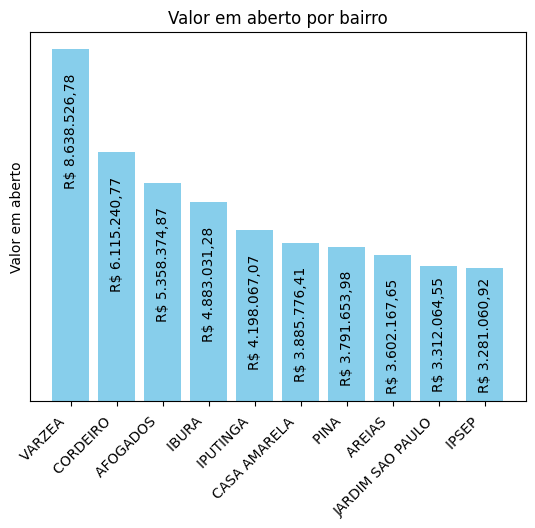

In [730]:
filtrando = filtrando.head(10)

fig, ax = plt.subplots()
filtrando = filtrando.sort_values(by='vlr_aberto', ascending=False)

bars = ax.bar(filtrando['bairro'], filtrando['vlr_aberto'], color='Skyblue')

ax.set_ylabel('Valor em aberto')
ax.set_title('Valor em aberto por bairro')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks([])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 1:
        xytext_config = (0, -100) 
    elif 1 <= i < 8:
        xytext_config = (0, -100) 
    else:
        xytext_config = (0, -90)
    
    ax.annotate(formatar_moeda(yval),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.show()

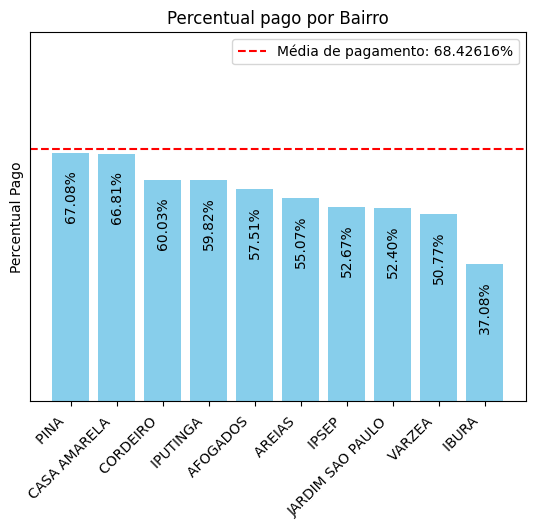

In [733]:
filtrando = pd.DataFrame(filtrando)

filtrando = filtrando.head(10)
filtrando = filtrando.sort_values(by='percentual_pago', ascending=False)

fig, ax = plt.subplots()

bars = ax.bar(filtrando['bairro'], filtrando['percentual_pago'], color='Skyblue')
ax.set_yticklabels([formatar_moeda(y) for y in ax.get_yticks()])

percentual_desejado = 68.42616
ax.axhline(y=percentual_desejado, color='r', linestyle='--', label=f'Média de pagamento: {percentual_desejado}%')

ax.set_ylabel('Percentual Pago')
ax.set_title('Percentual pago por Bairro')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks(range(0, 101, 10))

ax.legend()

ax.set_yticks([])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 1:
        xytext_config = (0, -50)
    elif 1 <= i < 8:
        xytext_config = (0, -50)
    else:
        xytext_config = (0, -50)
    
    ax.annotate(formatar_percentual(yval),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.show()

In [647]:
resultado['vlr_pago'].sum() / (resultado['vlr_aberto'].sum() + resultado['vlr_pago'].sum()) *100

68.4261620591365

In [663]:
filtro_2 = idade_imo_menor_50_anos[idade_imo_menor_50_anos['ano_fato_gerador'] == 2021]

In [670]:
bairro = pd.DataFrame(filtro_2)
resultado = bairro.groupby('bairro').agg({'vlr_aberto': 'sum', 'vlr_pago': 'sum'}).reset_index()
resultado = resultado.sort_values(by='vlr_aberto', ascending=False)
resultado['percentual_pago'] = resultado['vlr_pago'] / (resultado['vlr_aberto'] + resultado['vlr_pago']) *100

resultado['vlr_aberto'] = resultado['vlr_aberto'].apply(formatar_moeda)
resultado['vlr_pago'] = resultado['vlr_pago'].apply(formatar_moeda)
filtrando = resultado.query('percentual_pago < 95.6444')
filtrando = filtrando.sort_values(by='percentual_pago', ascending=True)
filtrando.head(20)

,bairro,vlr_aberto,vlr_pago,percentual_pago
67,PASSARINHO,"R$ 24.330,24","R$ 24.876,59",50.555157
64,NOVA DESCOBERTA,"R$ 51.047,27","R$ 241.315,92",82.539775
87,TORREAO,"R$ 92.948,24","R$ 673.280,15",87.869382
30,COQUEIRAL,"R$ 21.186,31","R$ 163.465,12",88.526322
17,BREJO DA GUABIRABA,"R$ 22.047,98","R$ 216.753,28",90.767226
36,DOIS UNIDOS,"R$ 17.241,71","R$ 197.222,40",91.960562
59,MANGABEIRA,"R$ 18.532,72","R$ 219.933,82",92.228377
61,MONTEIRO,"R$ 199.966,42","R$ 2.455.192,57",92.468759
69,PINA,"R$ 558.571,19","R$ 6.895.934,86",92.506932
91,VASCO DA GAMA,"R$ 54.639,64","R$ 691.630,52",92.678303


---

## Análise Descritiva

In [632]:
grupo_por_ano = filtro_1.groupby(['ano_fato_gerador', 'bairro']).apply(calcular_percentual_e_oportunidade)
grupo_por_ano = grupo_por_ano.reset_index()

bairros_top20 = grupo_por_ano.groupby('bairro')['vlr_aberto_total'].sum().nlargest(20).index
grupo_por_ano_top20 = grupo_por_ano[grupo_por_ano['bairro'].isin(bairros_top20)]

grupo_por_ano_top20 = grupo_por_ano_top20.sort_values(by='vlr_aberto_total', ascending=False)

tabela_pivotada = grupo_por_ano_top20.pivot(index='ano_fato_gerador', columns='bairro', values='percentual_pago')
tabela_pivotada


bairro,AFOGADOS,AREIAS,ARRUDA,BOA VIAGEM,BOA VISTA,CAMPO GRANDE,CASA AMARELA,CORDEIRO,ESPINHEIRO,GRACAS,IBURA,IMBIRIBEIRA,IPSEP,IPUTINGA,JARDIM SAO PAULO,MADALENA,PINA,SAN MARTIN,SANTO AMARO,VARZEA
ano_fato_gerador,,,,,,,,,,,,,,,,,,,,
2021.0,94.695383,96.680110,96.465728,95.559736,97.362207,94.087635,97.145081,93.742681,96.100012,96.728323,96.019392,94.558079,94.705989,93.781489,93.202749,94.779238,92.506932,96.738218,98.181518,96.136419
2022.0,57.505988,55.072179,40.083793,80.379794,80.871105,52.700676,66.810873,60.026279,79.699564,86.419487,37.077150,69.939041,52.665302,59.816971,52.399489,74.011645,67.080003,56.683199,75.614355,50.771939
2023.0,57.870210,57.115375,41.410164,78.484613,79.145670,54.120771,65.948121,60.898792,76.716855,84.935584,39.339952,70.020100,52.990554,59.789239,56.518187,73.205669,66.348754,59.708802,75.320600,52.504683


In [148]:
diff_df = tabela_pivotada.loc[2021] - tabela_pivotada.loc[2022]
resultado_df = pd.DataFrame(diff_df).T
resultado_df

bairro,AFOGADOS,AREIAS,ARRUDA,BOA VIAGEM,BOA VISTA,CAMPO GRANDE,CASA AMARELA,CORDEIRO,ESPINHEIRO,GRACAS,IBURA,IMBIRIBEIRA,IPSEP,IPUTINGA,JARDIM SAO PAULO,MADALENA,PINA,SAN MARTIN,SANTO AMARO,VARZEA
0,37.189394,41.607931,56.381935,15.179943,16.491102,41.386959,30.334208,33.716402,16.400448,10.308837,58.942242,24.619038,42.040687,33.964519,40.803261,20.767593,25.426929,40.055019,22.567163,45.36448


A média é de 32% de queda de arrecadação

Os bairros : AFOGADOS, AREIAS, ARRUDA, CAMPO GRANDE, CORDEIRO, IBURA, IPSEP, JARDIM SAO PAULO, SAN MARTIN E VARZEA obtiveram queda superior a 32% .

Os bairros mais distantes da média: IBURA(58,94%), ARRUDA(56,38%),  VARZEA(45,36%), IPSEP(42,04%)
COM VALOR EM ABERTO DE = R$ 43.162.491,37

In [150]:
diff_df = tabela_pivotada.loc[2021] - tabela_pivotada.loc[2022]
media_resultado = diff_df.mean()

media_df = pd.DataFrame({'Media': [media_resultado]})
print(media_df)


       Media
0  32.677404


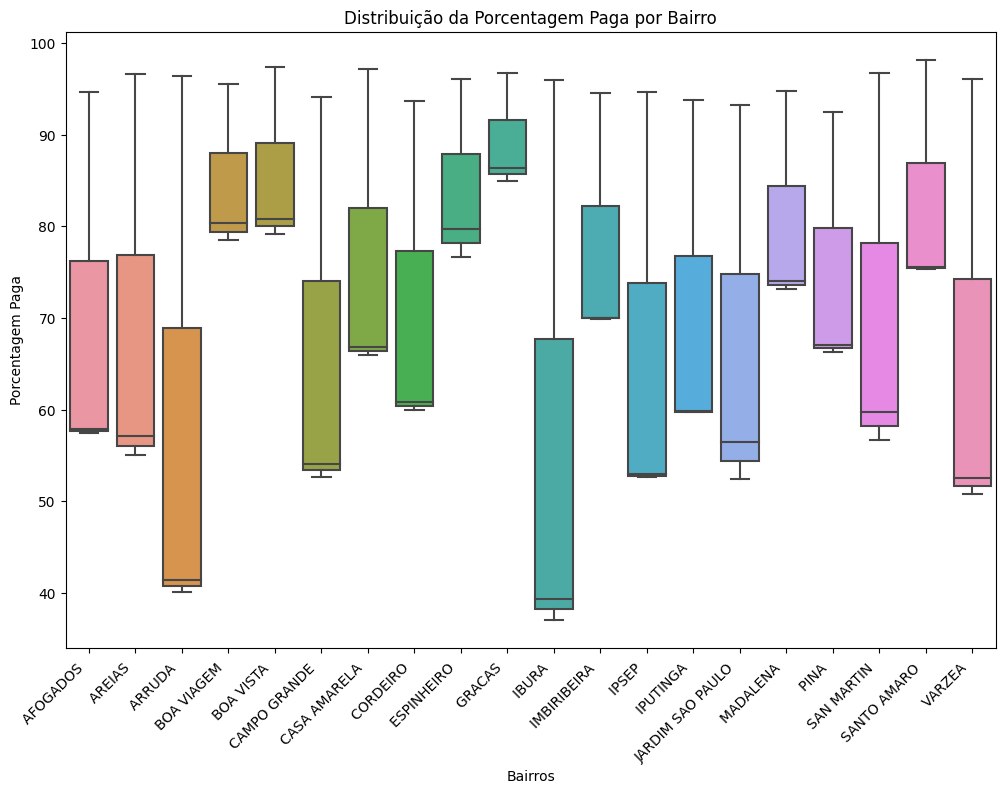

In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

media_por_bairro = tabela_pivotada.mean()
desvio_padrao_por_bairro = tabela_pivotada.std()

confianca = 0.95
graus_de_liberdade = tabela_pivotada.shape[0] - 1

erro_padrao_media = desvio_padrao_por_bairro / np.sqrt(tabela_pivotada.shape[0])

intervalo_confianca = t.interval(confianca, graus_de_liberdade, loc=media_por_bairro, scale=erro_padrao_media)

for bairro in tabela_pivotada.columns:
    col_index = tabela_pivotada.columns.get_loc(bairro)
    if (media_por_bairro[col_index] < intervalo_confianca[0][col_index]) or (media_por_bairro[col_index] > intervalo_confianca[1][col_index]):
        print(f'Bairro {bairro} com média fora do intervalo de confiança.')

tabela_pivotada_melted = tabela_pivotada.melt(var_name='Bairro', value_name='Percentual Pago')
plt.figure(figsize=(12, 8))
sns.boxplot(x='Bairro', y='Percentual Pago', data=tabela_pivotada_melted)
plt.title('Distribuição da Porcentagem Paga por Bairro')
plt.xlabel('Bairros')
plt.ylabel('Porcentagem Paga')
plt.xticks(rotation=45, ha='right')
plt.show()

As observações neste gráficos é que:

os bairros:
AFOGADOS ,AREIAS, CAMPO GRANDE, CASA AMARELA, CORDEIRO, IMBIRIBEIRA, IPSEP, IPUTINGA, JARDIM SAO PAULO, MADALENA, PINA, SAN MARTIN, VARZEA

se consentram na parte central do gráfico onde pode se haver oportunidade

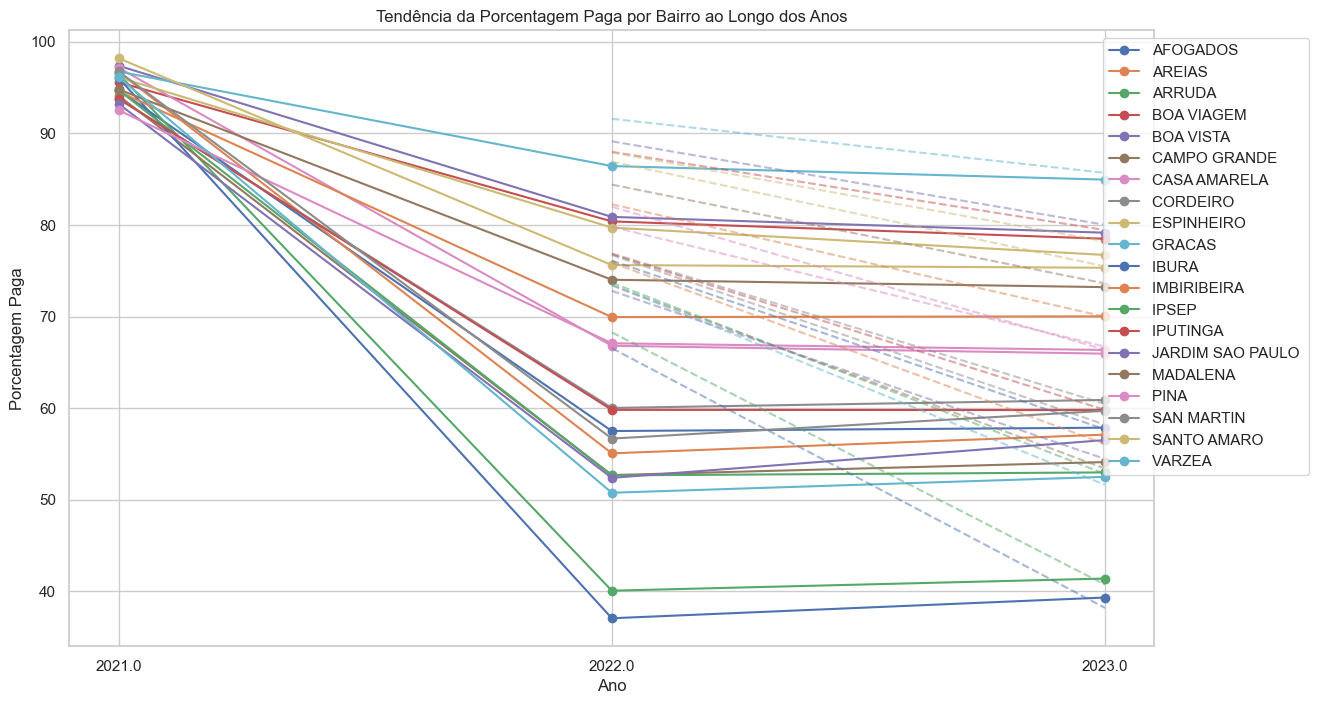

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

for bairro in tabela_pivotada.columns:
    plt.plot(tabela_pivotada.index, tabela_pivotada[bairro], label=bairro, marker='o')

plt.title('Tendência da Porcentagem Paga por Bairro ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Porcentagem Paga')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(ticks=tabela_pivotada.index, labels=tabela_pivotada.index)

for bairro in tabela_pivotada.columns:
    tabela_pivotada[bairro + '_media_movel'] = tabela_pivotada[bairro].rolling(window=2).mean()
    plt.plot(tabela_pivotada.index, tabela_pivotada[bairro + '_media_movel'], linestyle='dashed', alpha=0.5)

plt.show()


In [141]:
# Calcular a média geral das porcentagens pagas para cada ano
media_geral = tabela_pivotada.mean(axis=1)

# Normalizar as porcentagens pagas de cada bairro em relação à média geral
tabela_pivotada_relativo_geral = tabela_pivotada.sub(media_geral, axis=0)

# Identificar o bairro líder
bairro_lider = tabela_pivotada.mean().idxmax()

# Normalizar as porcentagens pagas de cada bairro em relação ao bairro líder
tabela_pivotada_relativo_lider = tabela_pivotada.div(tabela_pivotada[bairro_lider], axis=0)

# Identificar bairros cujas porcentagens relativas estão consistentemente abaixo da média geral
bairros_abaixo_media_geral = tabela_pivotada_relativo_geral.columns[tabela_pivotada_relativo_geral.lt(0).all(axis=0)]

# Identificar bairros cujas porcentagens relativas estão consistentemente abaixo do bairro líder
bairros_abaixo_lider = tabela_pivotada_relativo_lider.columns[tabela_pivotada_relativo_lider.lt(1).all(axis=0)]

# Exibir os resultados
print(f'Bairros consistentemente abaixo da média geral: {bairros_abaixo_media_geral}')
print(f'Bairros consistentemente abaixo do bairro líder ({bairro_lider}): {bairros_abaixo_lider}')


Bairros consistentemente abaixo da média geral: Index(['AFOGADOS _relativo_geral', 'AREIAS _relativo_geral',
       'ARRUDA _relativo_geral', 'BOA VIAGEM _relativo_geral',
       'BOA VISTA _relativo_geral', 'CAMPO GRANDE _relativo_geral',
       'CASA AMARELA _relativo_geral', 'CORDEIRO _relativo_geral',
       'ESPINHEIRO _relativo_geral', 'GRACAS _relativo_geral',
       ...
       'IBURA _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'IMBIRIBEIRA _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'IPSEP _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'IPUTINGA _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'JARDIM SAO PAULO _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'MADALENA _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'PINA _relativo_geral_relativo_lider_relativo_geral_relativo_lider',
       'SAN MARTIN _relativo_geral_relativo_lider_relativo

---

In [83]:
formatar_moeda(grupo_por_ano['vlr_aberto_total'].sum())

'R$ 417.766.644,96'

In [106]:
filtro = grupo_por_ano.head(20)
formatar_moeda(filtro['vlr_aberto_total'].sum())

'R$ 273.974.208,47'

In [107]:
(273974208.47 / 417766644.96) * 100

65.58068045289549

In [110]:
20/94 * 100

21.27659574468085

In [45]:
formatar_moeda(idade_imo_menor_50_anos['vlr_aberto'].sum())

'R$ 417,766,644.96'

In [50]:
formatar_moeda(idade_imo_menor_50_anos['vlr_pago'].sum())

'R$ 2,047,929,984.30'

In [357]:
filtro = idade_imo_menor_50_anos.query('tamanho_imovel == "INDEFINIDO"')
soma = formatar_moeda(filtro['vlr_aberto'].sum())
soma

'R$ 115,718,730.58'

In [358]:
115718730.58 / (115718730.58 + 391638749.71) * 100

22.808125449112616

In [97]:
filtro = idade_imo_menor_50_anos.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['tipo_propriedade'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_count', ascending=False).drop(columns='total_count')
pivot_table


,tipo_propriedade,PEQUENO,MEDIO,GRANDE,INDEFINIDO
0,APARTAMENTO,9352,29692,49688,0
1,CASA,31983,19978,12829,0
16,SALA,4201,4909,749,0
13,LOJA,4005,3036,1349,0
4,GALPÃO,0,0,0,2111
6,GARAGEM COMERCIAL,1392,4,3,0
3,EDIFICAÇÃO ESPECIAL,0,0,0,1334
14,MOCAMBO,0,0,0,524
9,HOTEL,0,0,0,384
12,INSTITUIÇÃO FINANCEIRA,0,0,0,164


In [375]:
filtro = idade_imo_menor_50_anos.query('tamanho_imovel == "INDEFINIDO"')
soma = formatar_moeda(filtro['vlr_aberto'].sum())
soma

'R$ 115,718,730.58'

In [376]:
115718730.58 / (115718730.58 + 391638749.71) * 100

22.808125449112616

### Soma por porte

In [98]:
soma_colunas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=0)
df_soma_colunas = pd.DataFrame(soma_colunas, columns=['Soma_Total'])
df_soma_colunas = df_soma_colunas.T
df_soma_colunas

,PEQUENO,MEDIO,GRANDE,INDEFINIDO
Soma_Total,50933,57619,64618,4846


In [369]:
50933 + 57619 + 64618 + 4846

178016

In [373]:
50933 / 178016 * 100

28.611473126011145

### Soma por tipo_propriedade

In [99]:
soma_linhas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=1)
df_soma_linhas = pd.DataFrame({'tipo_propriedade': pivot_table['tipo_propriedade'], 'Soma_Total': soma_linhas})
df_soma_linhas

,tipo_propriedade,Soma_Total
0,APARTAMENTO,88732
1,CASA,64790
16,SALA,9859
13,LOJA,8390
4,GALPÃO,2111
6,GARAGEM COMERCIAL,1399
3,EDIFICAÇÃO ESPECIAL,1334
14,MOCAMBO,524
9,HOTEL,384
12,INSTITUIÇÃO FINANCEIRA,164


In [41]:
filtro = idade_imo_menor_50_anos.query('tamanho_imovel == "MEDIO"')
filtro = filtro.query('tipo_propriedade == "APARTAMENTO"')
filtro = filtro.query('vlr_aberto > 0')

contagem_bairros = filtro.groupby('bairro')['id_imovel'].nunique().reset_index()
contagem_bairros.columns = ['bairro', 'quantidade_id_imovel']
contagem_bairros['soma_vlr_aberto'] = filtro.groupby('bairro')['vlr_aberto'].sum().values
# contagem_bairros['Pode_ser_pago'] = contagem_bairros['soma_vlr_aberto'] * 0.72
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)

# contagem_bairros['soma_vlr_aberto'] = contagem_bairros['soma_vlr_aberto'].apply(formatar_moeda)
# contagem_bairros['Pode_ser_pago'] = contagem_bairros['Pode_ser_pago'].apply(formatar_moeda)

contagem_bairros.head(10)

,bairro,quantidade_id_imovel,soma_vlr_aberto
10,BOA VIAGEM,1284,2621778.52
76,VARZEA,1310,2168476.12
41,IMBIRIBEIRA,1110,1781914.02
7,AREIAS,1150,1589473.56
43,IPUTINGA,977,1533650.79
26,CORDEIRO,831,1266866.15
72,TORRE,617,1239316.74
8,ARRUDA,738,982711.17
44,JARDIM SAO PAULO,539,694412.80
11,BOA VISTA,296,580276.06


In [323]:
formatar_moeda(contagem_bairros['soma_vlr_aberto'].sum())

'R$ 34,431,057.59'

In [324]:
formatar_moeda(contagem_bairros['Pode_ser_pago'].sum())

'R$ 24,790,361.46'

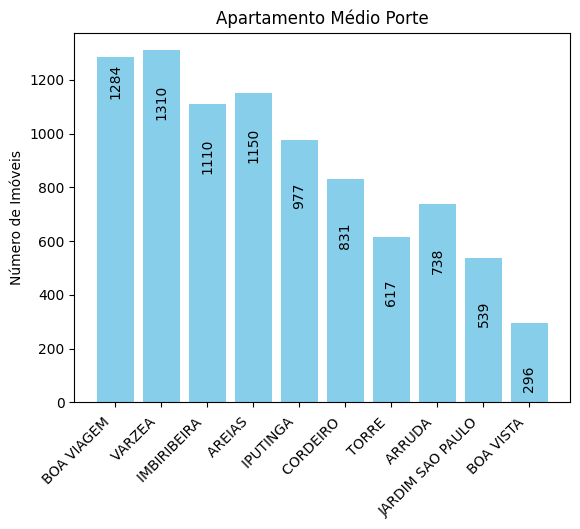

In [44]:
import matplotlib.pyplot as plt

# def formatar_moeda(valor):
#     return f'R$ {valor:,.2f}'

contagem_bairros = contagem_bairros.head(10)

fig, ax = plt.subplots()
# contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)

bars = ax.bar(contagem_bairros['bairro'], contagem_bairros['quantidade_id_imovel'], color='Skyblue')

# ax.set_xlabel('Bairros')
ax.set_ylabel('Número de Imóveis')
ax.set_title('Apartamento Médio Porte')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# ax.set_yticks([])

# Definir configurações de xytext com base nas condições
for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 1:
        xytext_config = (0, -50)  # Configuração para as 6 primeiras barras
    elif 1 <= i < 8:
        xytext_config = (0, -50)  # Configuração para as barras 7 e 8
    else:
        xytext_config = (0, -50)  # Configuração para as últimas barras
    
    ax.annotate(yval,
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)

plt.show()


In [118]:
filtro = idade_imo_menor_50_anos.query('tamanho_imovel == "GRANDE"')
filtro = filtro.query('tipo_propriedade == "CASA"')

filtro = filtro[filtro['bairro'].str.strip() == 'AFOGADOS']
soma = formatar_moeda(filtro['vlr_aberto'].sum())
soma

'R$ 3.585.287,29'

## Análise imóveis com idade maior que 50 anos

In [ ]:
idade_imo_maior_50_anos = debitos_divida.query('idade_imovel > 50')
idade_imo_maior_50_anos

In [275]:
filtro = idade_imo_maior_50_anos.query('tamanho_imovel in ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]')
pivot_table = pd.pivot_table(filtro, values='id_imovel', 
                             index=['tipo_propriedade'], 
                             columns=['tamanho_imovel'], 
                             aggfunc=pd.Series.nunique, 
                             fill_value=0)

pivot_table.columns = [f'{col}' for col in pivot_table.columns]

column_order = ["PEQUENO", "MEDIO", "GRANDE", "INDEFINIDO"]
pivot_table = pivot_table[column_order]

pivot_table = pivot_table.reset_index()

pivot_table['total_count'] = pivot_table.iloc[:, 1:].sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_count', ascending=False).drop(columns='total_count')
pivot_table


,tipo_propriedade,PEQUENO,MEDIO,GRANDE,INDEFINIDO
1,CASA,14109,13382,8524,0
0,APARTAMENTO,4616,10892,6707,0
13,LOJA,2588,2371,1591,0
17,SALA,3141,1033,1036,0
3,EDIFICAÇÃO ESPECIAL,0,0,0,1319
4,GALPÃO,0,0,0,607
12,INSTITUIÇÃO FINANCEIRA,0,0,0,255
10,INDUSTRIA,0,0,0,143
15,MOCAMBO,0,0,0,112
9,HOTEL,0,0,0,97


In [276]:
soma_colunas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=0)
df_soma_colunas = pd.DataFrame(soma_colunas, columns=['Soma_Total'])
df_soma_colunas = df_soma_colunas.T
df_soma_colunas

,PEQUENO,MEDIO,GRANDE,INDEFINIDO
Soma_Total,24486,27679,17859,2688


In [380]:
24486 + 27679 + 17859 + 2688

72712

In [384]:
2688 / 72712 * 100

3.696776323027836

In [378]:
filtro = idade_imo_maior_50_anos.query('tamanho_imovel == "INDEFINIDO"')
soma = formatar_moeda(filtro['vlr_pago'].sum())
soma

'R$ 237,139,235.09'

In [379]:
56455559.41 / (56455559.41 + 237139235.09) * 100

19.229073698716412

In [277]:
soma_linhas = pivot_table.drop(columns=['tipo_propriedade']).sum(axis=1)
df_soma_linhas = pd.DataFrame({'tipo_propriedade': pivot_table['tipo_propriedade'], 'Soma_Total': soma_linhas})
df_soma_linhas

,tipo_propriedade,Soma_Total
1,CASA,36015
0,APARTAMENTO,22215
13,LOJA,6550
17,SALA,5210
3,EDIFICAÇÃO ESPECIAL,1319
4,GALPÃO,607
12,INSTITUIÇÃO FINANCEIRA,255
10,INDUSTRIA,143
15,MOCAMBO,112
9,HOTEL,97


In [348]:
filtro = idade_imo_maior_50_anos.query('tamanho_imovel == "GRANDE"')
# filtro = filtro.query('tipo_propriedade == "APARTAMENTO"')
filtro = filtro.query('vlr_aberto > 0')

contagem_bairros = filtro.groupby('bairro')['id_imovel'].nunique().reset_index()
contagem_bairros.columns = ['bairro', 'quantidade_id_imovel']
contagem_bairros['soma_vlr_aberto'] = filtro.groupby('bairro')['vlr_aberto'].sum().values
contagem_bairros['Pode_ser_pago'] = contagem_bairros['soma_vlr_aberto'] * 0.81
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)
# contagem_bairros['soma_vlr_aberto'] = contagem_bairros['soma_vlr_aberto'].apply(formatar_moeda)

contagem_bairros

,bairro,quantidade_id_imovel,soma_vlr_aberto,Pode_ser_pago
11,BOA VIAGEM,1278,9884523.51,8.006464e+06
12,BOA VISTA,711,9595014.90,7.771962e+06
71,SANTO AMARO,567,6795583.84,5.504423e+06
72,SANTO ANTONIO,483,6090671.51,4.933444e+06
73,SAO JOSE,232,4275298.34,3.462992e+06
...,...,...,...,...
16,BREJO DE BEBERIBE,1,11414.66,9.245875e+03
27,COHAB,2,6121.72,4.958593e+03
4,ALTO JOSE BONIFACIO,1,4180.01,3.385808e+03
56,MORRO DA CONCEICAO,1,2804.21,2.271410e+03


In [349]:
formatar_moeda(contagem_bairros['soma_vlr_aberto'].sum())

'R$ 83,403,032.45'

In [350]:
formatar_moeda(contagem_bairros['Pode_ser_pago'].sum())

'R$ 67,556,456.28'

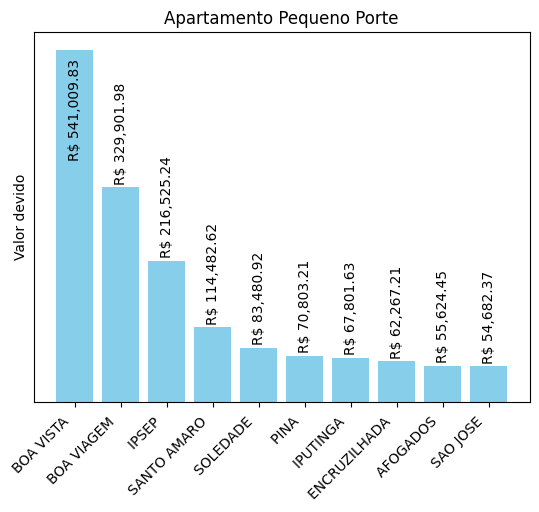

In [299]:
import matplotlib.pyplot as plt

def formatar_moeda(valor):
    return f'R$ {valor:,.2f}'

contagem_bairros = contagem_bairros.head(10)
fig, ax = plt.subplots()
contagem_bairros = contagem_bairros.sort_values(by='soma_vlr_aberto', ascending=False)
bars = ax.bar(contagem_bairros['bairro'], contagem_bairros['soma_vlr_aberto'], color='skyblue')

# ax.set_xlabel('Bairros')
ax.set_ylabel('Valor devido')
ax.set_title('Apartamento Pequeno Porte')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks([])

for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    if i < 1:
        xytext_config = (0, -80) 
    elif 1 <= i < 9:
        xytext_config = (0, 2) 
    else:
        xytext_config = (0, 2) 
    ax.annotate(formatar_moeda(yval),
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=xytext_config,
                textcoords="offset points",
                ha='center', va='bottom', rotation=90)
plt.show()

In [387]:
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,...,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam,tamanho_imovel,regiao,rpa,porcentagem_acumulada
1898698,f128a0b5a535ad28,e8f94ca7dc74292c875350beaddc7871,902e24b5961f823ecb4aa8913c97fe7e,2022.0,10,27221.25,1,P,INSTITUIÇÃO EDUCACIONAL,CONSTRUÍDA,...,2022-12-16,0.0,58.0,0.00,1433342.42,1433342.42,INDEFINIDO,SUL,6,0.171681
1898697,f128a0b5a535ad28,73bab351afd1640d90ecf5aaf6be6eb7,902e24b5961f823ecb4aa8913c97fe7e,2023.0,10,27221.25,1,P,INSTITUIÇÃO EDUCACIONAL,CONSTRUÍDA,...,2023-03-15,0.0,58.0,0.00,1274193.28,1274193.28,INDEFINIDO,SUL,6,0.324299
561852,471cdd94229eb9d7,63a6a9ab7fe94d53875350beaddc7871,909b6c1fd705cb6cb64f7a574789a74a,2022.0,1,30986.62,1,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,2022-12-16,0.0,37.0,0.00,1109011.71,1109011.71,INDEFINIDO,NORTE,2,0.457133
97552,0c64a64b5dd369e3,8dd3e3311374f98a875350beaddc7871,c7a42af8cb6fcf9866e28604cfd7774b,2022.0,1,75031.37,1,P,INDUSTRIA,CONSTRUÍDA,...,2022-12-16,0.0,41.0,473896.42,1093110.53,1568424.39,INDEFINIDO,SUDESTE,5,0.588062
1994331,fd105a1a70e3cae5,407b75bd5f47ff03875350beaddc7871,15d4d0ac97cfbc7f62f546f4fdd231a3,2022.0,1,72704.81,1,P,EDIFICAÇÃO ESPECIAL,CONSTRUÍDA,...,2022-12-16,0.0,42.0,0.00,1059101.96,1059101.96,INDEFINIDO,OESTE,4,0.714917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729064,5c471da1749c2a6e,b5abb64ad69f73c690ecf5aaf6be6eb7,ba1429f47c571667cd124eb8021f7dca,2023.0,1,41.17,1,P,LOJA,CONSTRUÍDA,...,2023-11-10,0.0,31.0,1311.51,0.00,1330.88,PEQUENO,NORDESTE,3A,100.000000
729063,5c471da1749c2a6e,8224b0bb8908d10b11babe4a46e18b6d,ba1429f47c571667cd124eb8021f7dca,2018.0,1,41.17,1,P,LOJA,CONSTRUÍDA,...,2018-11-09,0.0,31.0,997.10,0.00,997.10,PEQUENO,NORDESTE,3A,100.000000
729062,5c471da1749c2a6e,3af78fd611742a540ba9f03948490762,ba1429f47c571667cd124eb8021f7dca,2020.0,1,41.17,1,P,LOJA,CONSTRUÍDA,...,2021-02-10,1.0,31.0,890.94,0.00,930.83,PEQUENO,NORDESTE,3A,100.000000
729060,5c471da1749c2a6e,31d95836864c83b319002eec9f619408,ba1429f47c571667cd124eb8021f7dca,2021.0,1,41.17,1,P,LOJA,CONSTRUÍDA,...,2021-11-10,0.0,31.0,1102.70,0.00,1102.70,PEQUENO,NORDESTE,3A,100.000000


In [13]:
# Ordenar os dados pelo valor aberto em ordem decrescente
idade_imo_menor_50_anos = idade_imo_menor_50_anos.sort_values(by='vlr_aberto', ascending=False)
idade_imo_menor_50_anos['vlr_aberto'] = idade_imo_menor_50_anos['vlr_aberto'].astype(str)


# Calcular porcentagens acumuladas
total = idade_imo_menor_50_anos['vlr_aberto'].sum()
idade_imo_menor_50_anos['porcentagem_acumulada'] = idade_imo_menor_50_anos['vlr_aberto'].cumsum() / total * 100

# Criar o gráfico de Pareto
fig, ax1 = plt.subplots()

ax1.bar(idade_imo_menor_50_anos['bairro'], idade_imo_menor_50_anos['vlr_aberto'], color='tab:blue')
ax1.set_xlabel('Bairros')
ax1.set_ylabel('Valor em Aberto', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(idade_imo_menor_50_anos['bairro'], idade_imo_menor_50_anos['porcentagem_acumulada'], color='tab:red', marker='o')
ax2.set_ylabel('Porcentagem Acumulada', color='tab:red')

plt.title('Gráfico de Pareto - Valores em Aberto por Bairro')

plt.show()
